In [1]:
%cd ../..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/jeffrey-uso9-03-dev-ci01/code/Users/jeffrey.tackes/ModernTS_2E


In [2]:
import os
import shutil
import json

import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path

from tqdm.autonotebook import tqdm
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

from statsforecast import StatsForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.auto import AutoNBEATS
from neuralforecast.losses.pytorch import MQLoss
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mse, mase
from functools import partial

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

/tmp/ipykernel_51744/202940174.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-08-12 13:00:41,810	WARNING __init__.py:21 -- Package pickle5 becomes unnecessary in Python 3.8 and above. Its presence may confuse libraries including Ray. Please uninstall the package.
/anaconda/envs/demand_planning/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
TRAIN_SUBSAMPLE = False  # Trains a subsample of IDs to improve run speed
RETUNE = True  # if false, will use pre-trained hyperparameters when generating the AUTO NeuralForecast

In [4]:
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")
try:
    #Reading the missing value imputed and train test split data
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
    # Read in the Validation dataset as test_df so that we predict on it
    test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
    # test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed_feature_engg.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Feature Engineering.ipynb in Chapter06
    </div>
    """))

In [5]:
train_df.head(2)

timestamp      LCLid  energy_consumption frequency  series_length  \
0 2012-01-01 00:00:00  MAC000061               0.114     30min          37872   
1 2012-01-01 00:30:00  MAC000061               0.113     30min          37872   

  stdorToU    Acorn Acorn_grouped      file    holidays  ...  \
0      Std  ACORN-Q     Adversity  block_96  NO_HOLIDAY  ...   
1      Std  ACORN-Q     Adversity  block_96  NO_HOLIDAY  ...   

   timestamp_Minute_sin_1  timestamp_Minute_sin_2  timestamp_Minute_sin_3  \
0            0.000000e+00            0.000000e+00            0.000000e+00   
1            5.665539e-16           -1.133108e-15            2.143751e-15   

   timestamp_Minute_sin_4  timestamp_Minute_sin_5  timestamp_Minute_cos_1  \
0            0.000000e+00            0.000000e+00                     1.0   
1           -2.266215e-15            6.123234e-16                    -1.0   

   timestamp_Minute_cos_2 timestamp_Minute_cos_3 timestamp_Minute_cos_4  \
0                     1.0                    1.0                    1.0   
1                     1.0                   -1.0                    1.0   

   timestamp_Minute_cos_5  
0                     1.0  
1                    -1.0  

[2 rows x 94 columns]

In [6]:
print("Total # of IDs Pre-Sampling: ", len(train_df.LCLid.unique()))

Total # of IDs Pre-Sampling:  150


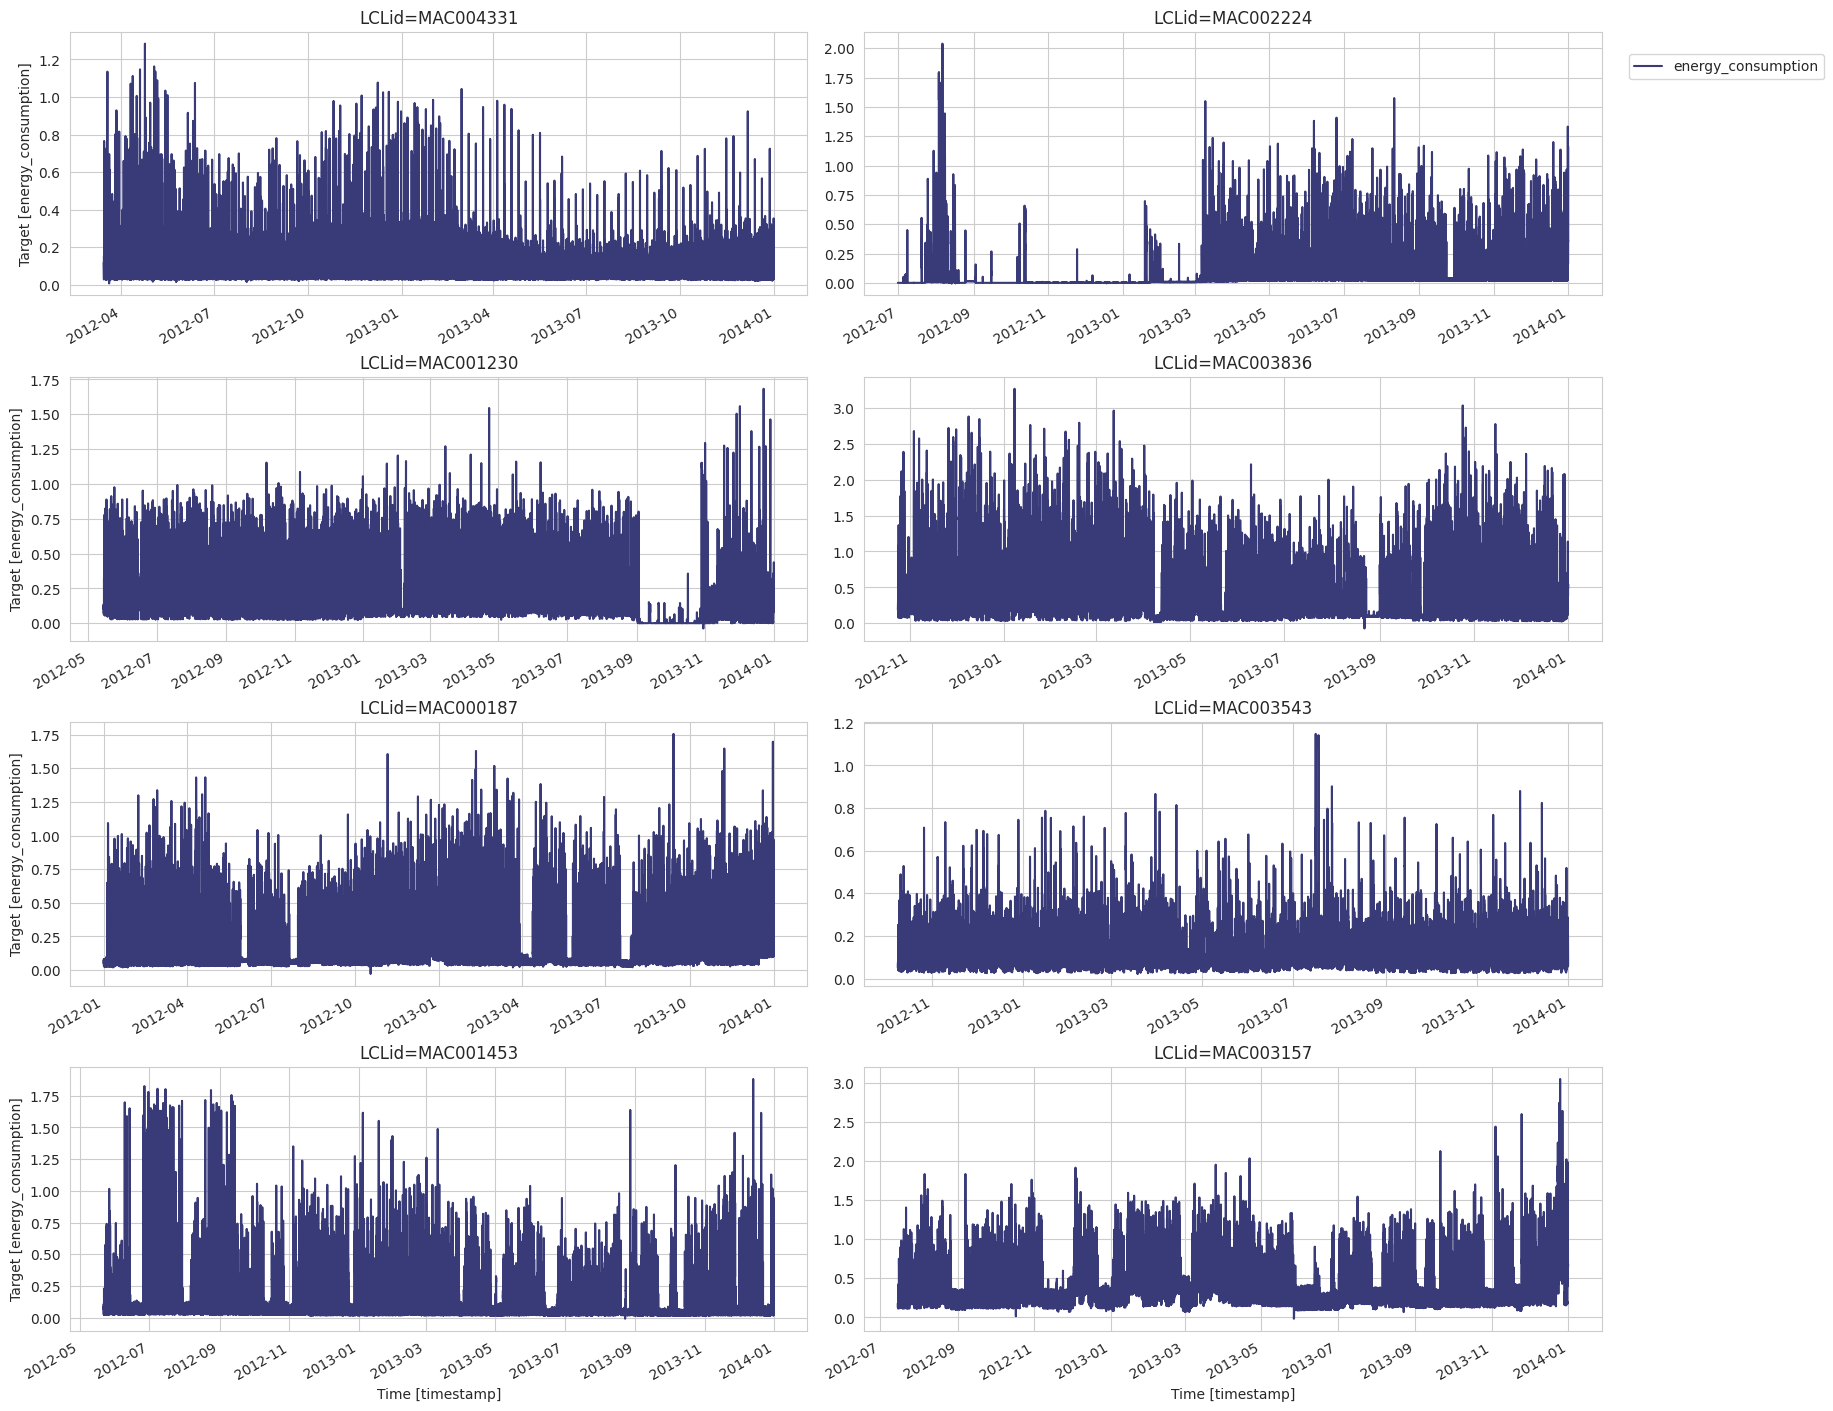

In [7]:
StatsForecast.plot(train_df, engine='matplotlib', id_col='LCLid',time_col= 'timestamp', target_col='energy_consumption')

In [8]:
# To run on smaller set of data for daster iteration.
if TRAIN_SUBSAMPLE:
    print("sub sampling")
    SAMPLE = 10
    sampled_LCLids = pd.Series(train_df.LCLid.unique().remove_unused_categories().categories).sample(SAMPLE, random_state=99).tolist()
    train_df = train_df.loc[train_df.LCLid.isin(sampled_LCLids)]
    test_df = test_df.loc[test_df.LCLid.isin(sampled_LCLids)]

In [9]:
print("Total # of IDs Post Sampling: ", len(train_df.LCLid.unique()))

Total # of IDs Post Sampling:  150


## Train, Validation, Test Set

In [10]:
print("Training Min Date: ", train_df.timestamp.min(), 
      "\nTraining Max Date: ", train_df.timestamp.max(), 
      "\nTesting Min Date: ", test_df.timestamp.min(),
      "\nTesting Max Date: ", test_df.timestamp.max()
)

Training Min Date:  2012-01-01 00:00:00 
Training Max Date:  2013-12-31 23:30:00 
Testing Min Date:  2014-01-01 00:00:00 
Testing Max Date:  2014-01-31 23:30:00


In [11]:
#Keeping 1 days aside as a validation set
cutoff = train_df.timestamp.max() - pd.Timedelta(1, "D")

validation_df = train_df[(train_df.timestamp>cutoff)].reset_index(drop=True) # validation prediction set
training_df = train_df[(train_df.timestamp<=cutoff)].reset_index(drop=True) # training set used for validation set

print(f"Train Max: {training_df.timestamp.max()} \nValidation Min: {validation_df.timestamp.min()} \nValidation Max: {validation_df.timestamp.max()}")
print(f"Validation Horizon: {len(validation_df.timestamp.unique())}")


Train Max: 2013-12-30 23:30:00 
Validation Min: 2013-12-31 00:00:00 
Validation Max: 2013-12-31 23:30:00
Validation Horizon: 48


##### Define Validation model parameters

In [12]:
h = 48
max_steps = 100

## Training NBEATS Model

In [13]:
model_untuned = [NBEATS(h=h,  input_size = 48*7,              
                max_steps=max_steps)]

model_untuned = NeuralForecast(models=model_untuned, freq='30min')
model_untuned.fit(training_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption')

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.2 M 
-----------------------------------------------
3.2 M     Trainable params
37.2 K    Non-trainable params
3.2 M     Total params
12.861    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.


In [14]:
# Get Predictions for validation
pred_df =  model_untuned.predict(futr_df=validation_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df = pred_df.merge(validation_df[['LCLid','timestamp','energy_consumption']], on=['LCLid','timestamp'], how='left')
pred_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LCLid           timestamp    NBEATS  energy_consumption
0  MAC000061 2013-12-31 00:00:00  0.115531               0.053
1  MAC000061 2013-12-31 00:30:00  0.095807               0.053
2  MAC000061 2013-12-31 01:00:00  0.071051               0.048
3  MAC000061 2013-12-31 01:30:00  0.055339               0.050
4  MAC000061 2013-12-31 02:00:00  0.053415               0.050

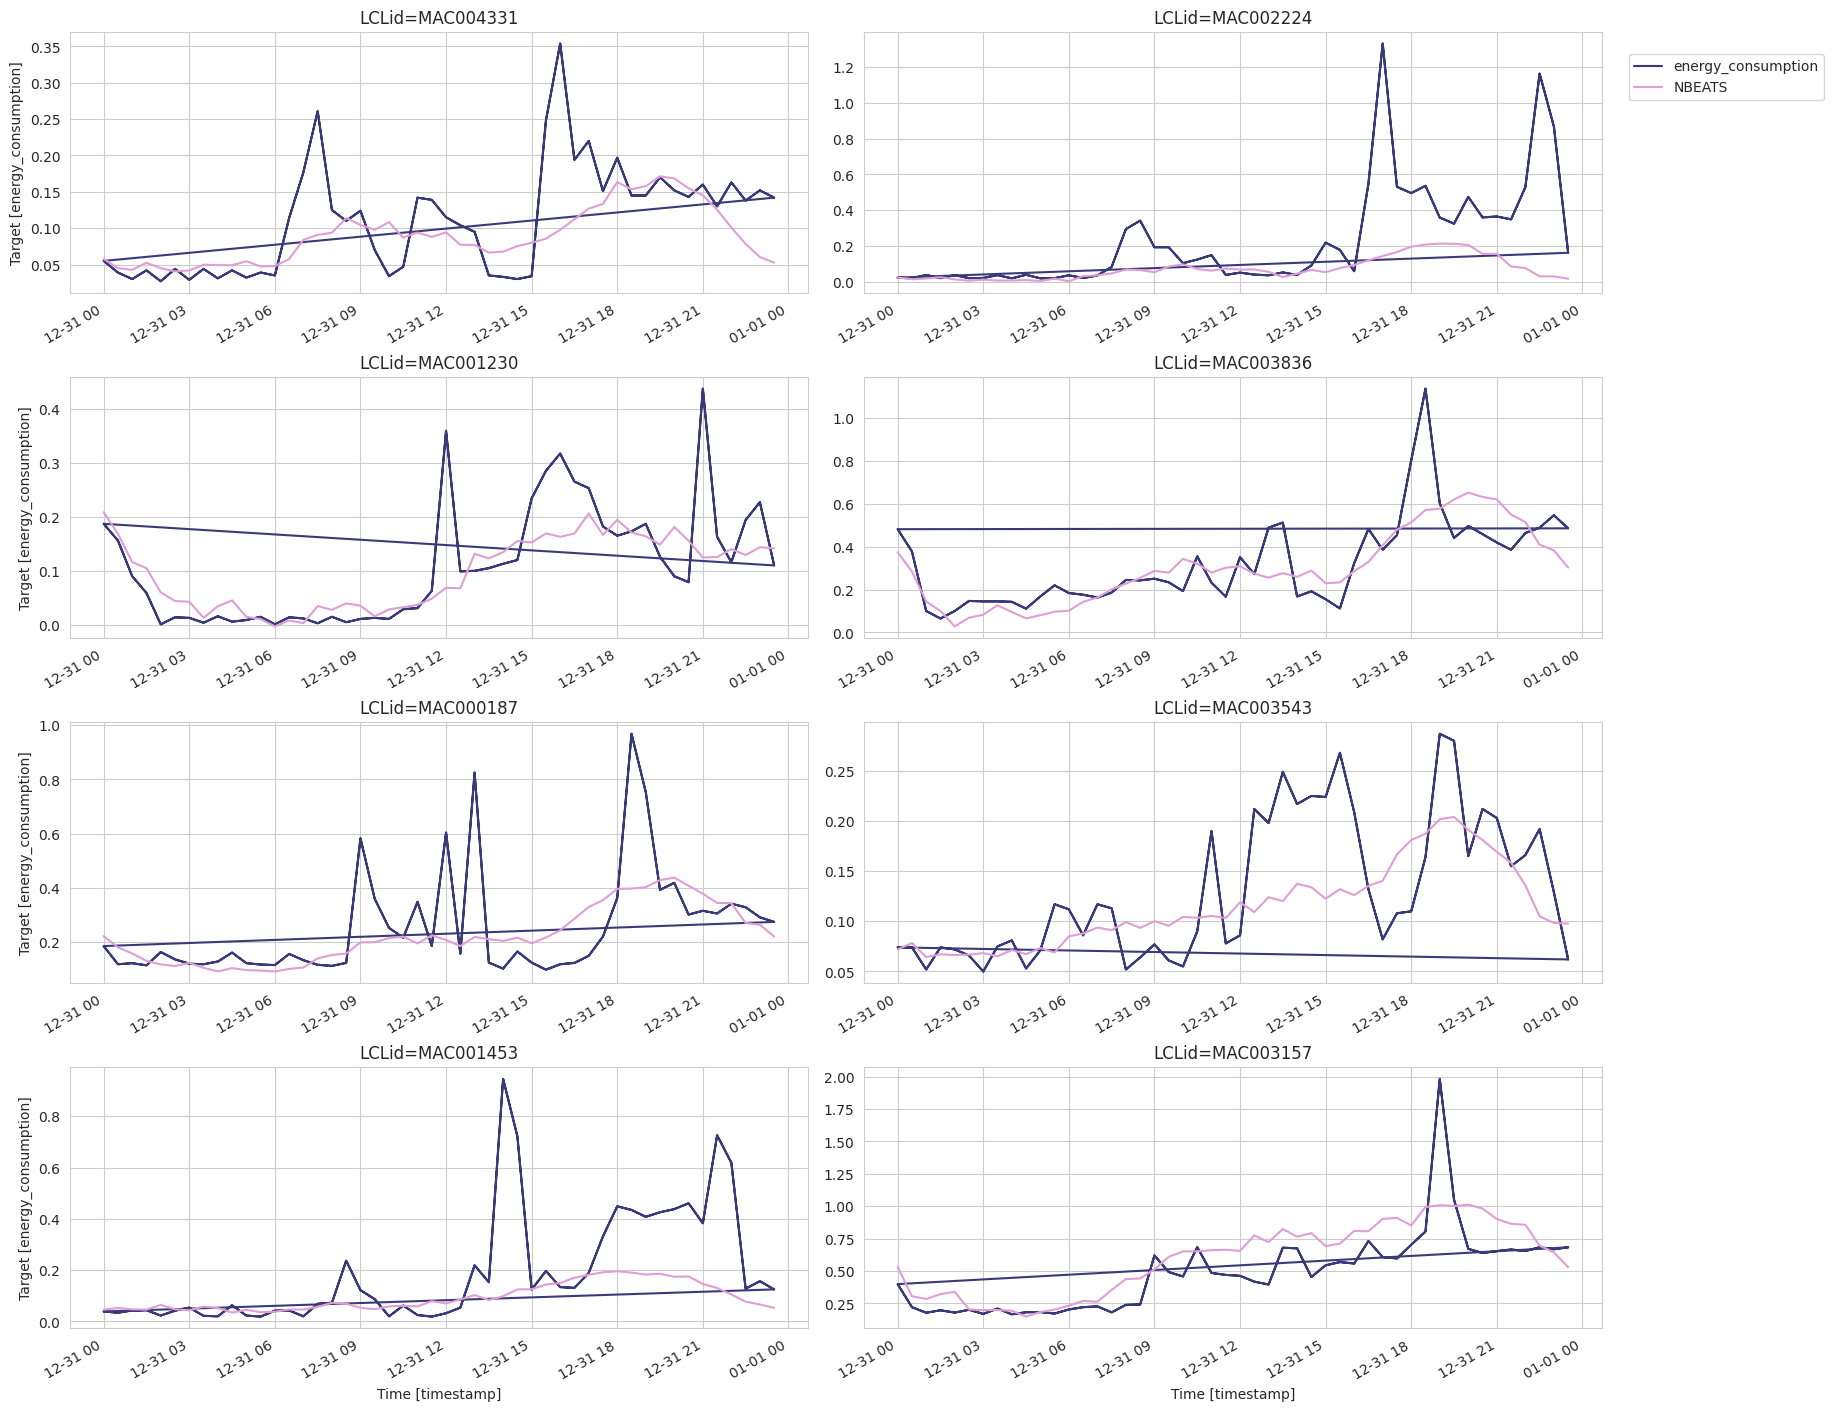

In [15]:
#visualize results
StatsForecast.plot(validation_df[['LCLid','timestamp','energy_consumption']], 
                   pred_df, engine='matplotlib', 
                   id_col='LCLid',
                   time_col= 'timestamp', 
                   target_col='energy_consumption',
                   models=['NBEATS'])

#### Evaluate NBEATS forecast

In [16]:
fcst_mase = partial(mase, seasonality=48)

# Get metrics for individual LCLid's
nbeats_metrics = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

# Get aggregated metrics for across all LCLid's by model
nbeats_metrics_agg = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [17]:
nbeats_metrics_agg

metric    NBEATS
0   rmse  0.160312
1    mae  0.101157
2    mse  0.048707
3   mase  0.916790

## NBEATS Tuned
Since hyperparameters are key to performance in Neural Networks, NIXTLA has made this search each through the incorporation of Auto forecast.
Each NeuralForecast model has an AUTO class which allow you to easily tune your hyperparameters.

Auto Forecast can time, you can load the pre-trained hyperparameters or choose to retune on your own.
Set ```RETUNE = True``` if you wish to retune.


In [24]:
# Define the file path
config_file_path = 'notebooks/Chapter16/saved_params_config/nbeats_best_config.json'
try:
    with open(config_file_path, 'r') as config_file:
        loaded_config = json.load(config_file)
        print(loaded_config)
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. 
    </div>
    """))
    

In [25]:
nbeats_config = {
    "max_steps": max_steps,  # This parameter can be adjusted if needed
    #"input_size": 48*7*2,  # Size of input window
    "input_size": tune.choice([h,h*7,h*7*2,h*7*3]),
    "learning_rate": tune.loguniform(1e-2, 1e-1),  # Initial learning rate
    "scaler_type": tune.choice(["minmax", "robust", "standard"]),
    #"dropout_prob_theta":tune.uniform(0, .1),
    "batch_size": tune.choice([32, 64])    
}

if RETUNE == True:
    models = [AutoNBEATS(h=h, 
                     config = nbeats_config,
                     search_alg = HyperOptSearch(),
                     backend = 'ray',
                     num_samples = 100,
                     cpus=1)]

else:
    models = [AutoNBEATS(h=h, 
                    config = loaded_config,
                    search_alg = None,
                    backend = 'ray',
                    cpus=1)]


model_tuned = NeuralForecast(models=models, freq='30min')
model_tuned.fit(training_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption', verbose = True)

(_train_tune pid=57658) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=57658) Seed set to 1
(_train_tune pid=57658) GPU available: False, used: False
(_train_tune pid=57658) TPU available: False, using: 0 TPU cores
(_train_tune pid=57658) IPU available: False, using: 0 IPUs
(_train_tune pid=57658) HPU available: False, using: 0 HPUs
(_train_tune pid=57658) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_8a714832_1_batch_size=64,h=48,input_size=1008,learning_rate=0.0681,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_13-07-47/lightning_logs
(_train_tune pid=57658) 
(_train_tune pid=57658)   | Name         | Type          | Params
(_train_tune pid=57658) ------------------------------------------

Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/3 [00:00<?, ?it/s]


(_train_tune pid=58027) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_train_tune pid=58027) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=57823) GPU available: False, used: False
(_train_tune pid=57823) TPU available: False, using: 0 TPU cores
(_train_tune pid=57823) IPU available: False, using: 0 IPUs
(_train_tune pid=57823) HPU available: False, using: 0 HPUs
(_train_tune pid=57823) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_d45a7974_2_batch_size=32,h=48,input_size=48,learning_rate=

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=58834) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead. [repeated 2x across cluster]
(_train_tune pid=58834) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=58554) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=58554) GPU available: False, used: False
(_train_tune pid=58554) TPU available: False, using: 0 TPU cores
(_train_tune pid=58554) IPU available: False, using: 0 IPUs
(_train_tune pid=58554) HPU available: False, using: 0 HPUs
(_train_tune pid=58554) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_f34dcc39_4_batch_size=64,h=48,input_size=672,learning_rate=0.0375,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-07-58/lightning_log

Epoch 0:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 4/5 [00:10<00:02,  0.38it/s, v_num=0, train_loss_step=9.43e+4]


(_train_tune pid=58834) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_fb16997e_5_batch_size=32,h=48,input_size=1008,learning_rate=0.0735,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_13-08-01/lightning_logs
(_train_tune pid=58834) 
(_train_tune pid=58834)   | Name         | Type          | Params
(_train_tune pid=58834) 0 | loss         | MAE           | 0     
(_train_tune pid=58834) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=58834) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=58834) 3 | blocks       | ModuleList    | 4.7 M 
(_train_tune pid=58834) 4.6 M     Trainable params
(_train_tune pid=58834) 102 K     Non-trainable params
(_train_tune pid=58834) 4.7 M     Total params
(_train_tune pid=58834) 18.630    Total estimated model params size (MB)


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/3 [00:00<?, ?it/s]


(_train_tune pid=59327) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead. [repeated 2x across cluster]
(_train_tune pid=59327) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=59086) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=59086) GPU available: False, used: False
(_train_tune pid=59086) TPU available: False, using: 0 TPU cores
(_train_tune pid=59086) IPU available: False, using: 0 IPUs
(_train_tune pid=59086) HPU available: False, using: 0 HPUs
(_train_tune pid=59086) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_ee479555_6_batch_size=64,h=48,input_size=336,learning_rate=0.0940,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-08-05/lightning_log

Epoch 3:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=9.64e+3, train_loss_epoch=1.68e+7]


(_train_tune pid=59327) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_ca8d8e06_7_batch_size=32,h=48,input_size=1008,learning_rate=0.0215,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_13-08-09/lightning_logs
(_train_tune pid=59327) 
(_train_tune pid=59327)   | Name         | Type          | Params
(_train_tune pid=59327) 0 | loss         | MAE           | 0     
(_train_tune pid=59327) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=59327) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=59327) 3 | blocks       | ModuleList    | 4.7 M 
(_train_tune pid=59327) 4.6 M     Trainable params
(_train_tune pid=59327) 102 K     Non-trainable params
(_train_tune pid=59327) 4.7 M     Total params
(_train_tune pid=59327) 18.630    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 46.61it/s]


(_train_tune pid=59821) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead. [repeated 2x across cluster]
(_train_tune pid=59821) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=59556) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=59556) GPU available: False, used: False
(_train_tune pid=59556) TPU available: False, using: 0 TPU cores
(_train_tune pid=59556) IPU available: False, using: 0 IPUs
(_train_tune pid=59556) HPU available: False, using: 0 HPUs
(_train_tune pid=59556) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_a1e42ab1_8_batch_size=32,h=48,input_size=336,learning_rate=0.0259,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-08-13/lightning_log

Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


(_train_tune pid=60344) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead. [repeated 2x across cluster]
(_train_tune pid=60085) Seed set to 1
(_train_tune pid=60085) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=60085) GPU available: False, used: False
(_train_tune pid=60085) TPU available: False, using: 0 TPU cores
(_train_tune pid=60085) IPU available: False, using: 0 IPUs
(_train_tune pid=60085) HPU available: False, using: 0 HPUs
(_train_tune pid=60085) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_1cdcc992_10_batch_size=32,h=48,input_size=1008,learning_rate=0.0321,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_13-08-21/lightning_logs
(_train_tune pid=60085) 
(_

Epoch 7:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [00:03<00:00,  1.30it/s, v_num=0, train_loss_step=9.42e+3, train_loss_epoch=1.93e+4] 

(_train_tune pid=60644) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=60344) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=60644) Seed set to 1
(_train_tune pid=60644) GPU available: False, used: False
(_train_tune pid=60644) TPU available: False, using: 0 TPU cores
(_train_tune pid=60644) IPU available: False, using: 0 IPUs
(_train_tune pid=60644) HPU available: False, using: 0 HPUs


Epoch 9:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 1/5 [00:00<00:03,  1.31it/s, v_num=0, train_loss_step=4.83e+3, train_loss_epoch=4.97e+3] 

(_train_tune pid=60898) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=60898) Seed set to 1
(_train_tune pid=60644) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_001fffe6_12_batch_size=32,h=48,input_size=48,learning_rate=0.0396,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-08-29/lightning_logs
(_train_tune pid=60644) 
(_train_tune pid=60644)   | Name         | Type          | Params
(_train_tune pid=60644) 0 | loss         | MAE           | 0     
(_train_tune pid=60644) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=60644) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=60644) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=60644) 2.6 M     Trainable p

Epoch 10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 2/5 [00:01<00:02,  1.25it/s, v_num=0, train_loss_step=3.72e+3, train_loss_epoch=4.06e+3] 

(_train_tune pid=60898) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=61196) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=61196) Seed set to 1
(_train_tune pid=61196) GPU available: False, used: False
(_train_tune pid=61196) TPU available: False, using: 0 TPU cores
(_train_tune pid=61196) IPU available: False, using: 0 IPUs
(_train_tune pid=61196) HPU available: False, using: 0 HPUs


Epoch 0:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 2/5 [00:11<00:16,  0.18it/s, v_num=0, train_loss_step=2.02e+10] 

(_train_tune pid=61504) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=61504) Seed set to 1
(_train_tune pid=61196) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_ab8dd29c_14_batch_size=64,h=48,input_size=1008,learning_rate=0.0565,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_13-08-38/lightning_logs
(_train_tune pid=61196) 
(_train_tune pid=61196)   | Name         | Type          | Params
(_train_tune pid=61196) 0 | loss         | MAE           | 0     
(_train_tune pid=61196) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=61196) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=61196) 3 | blocks       | ModuleList    | 4.7 M 
(_train_tune pid=61196) 4.6 M     Trainable p

Epoch 12:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 4/5 [00:03<00:00,  1.11it/s, v_num=0, train_loss_step=5.51e+3, train_loss_epoch=3.19e+3] 

(_train_tune pid=61801) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=61801) Seed set to 1
(_train_tune pid=61801) GPU available: False, used: False
(_train_tune pid=61801) TPU available: False, using: 0 TPU cores
(_train_tune pid=61801) IPU available: False, using: 0 IPUs
(_train_tune pid=61801) HPU available: False, using: 0 HPUs
(_train_tune pid=61801) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_ffcdaebb_16_batch_size=64,h=48,input_size=1008,learning_rate=0.0104,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_13-08-48/lightning_logs
(_train_tune pid=61801) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=61801) 
(_train_tune pid=61801)   | Nam

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=62126) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=62126) Seed set to 1
(_train_tune pid=62126) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_484b713f_17_batch_size=64,h=48,input_size=48,learning_rate=0.0151,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-08-53/lightning_logs
(_train_tune pid=62126) 
(_train_tune pid=62126)   | Name         | Type          | Params
(_train_tune pid=62126) 0 | loss         | MAE           | 0     
(_train_tune pid=62126) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=62126) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=62126) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=62126) 2.6 M     Trainable p

Epoch 1:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 2/5 [00:12<00:18,  0.16it/s, v_num=0, train_loss_step=1.64e+5, train_loss_epoch=4.16e+8] 

(_train_tune pid=62126) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=62426) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=62426) Seed set to 1
(_train_tune pid=62426) GPU available: False, used: False
(_train_tune pid=62426) TPU available: False, using: 0 TPU cores
(_train_tune pid=62426) IPU available: False, using: 0 IPUs
(_train_tune pid=62426) HPU available: False, using: 0 HPUs
(_train_tune pid=62426) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_0631d546_18_batch_size=64,h=48,input_size=336,learning_rate=0.0314,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_13-08-58/lightning_logs
(_train_tune pid=62426) 
(_train_tune pid=62426)   | Nam

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=62780) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=62780) Seed set to 1
(_train_tune pid=62426) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=62780) GPU available: False, used: False
(_train_tune pid=62780) TPU available: False, using: 0 TPU cores
(_train_tune pid=62780) IPU available: False, using: 0 IPUs
(_train_tune pid=62780) HPU available: False, using: 0 HPUs
(_train_tune pid=62780) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_8f9bdcb5_19_batch_size=32,h=48,input_size=672,learning_rate=0.0365,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_13-09-03/lightning_logs
(_train_tune pid=62780) 
(_train_tune pid=62780)   | Nam

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=63137) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=63137) Seed set to 1
(_train_tune pid=62780) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=63137) GPU available: False, used: False
(_train_tune pid=63137) TPU available: False, using: 0 TPU cores
(_train_tune pid=63137) IPU available: False, using: 0 IPUs
(_train_tune pid=63137) HPU available: False, using: 0 HPUs
(_train_tune pid=63137) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_64073340_20_batch_size=64,h=48,input_size=336,learning_rate=0.0299,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_13-09-09/lightning_logs
(_train_tune pid=63137) 
(_train_tune pid=63137)   | Nam

Epoch 3:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 1/3 [00:10<00:20,  0.10it/s, v_num=0, train_loss_step=5.33e+8, train_loss_epoch=5.55e+10] 

(_train_tune pid=63480) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=63480) Seed set to 1
(_train_tune pid=63137) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=63480) GPU available: False, used: False
(_train_tune pid=63480) TPU available: False, using: 0 TPU cores
(_train_tune pid=63480) IPU available: False, using: 0 IPUs
(_train_tune pid=63480) HPU available: False, using: 0 HPUs
(_train_tune pid=63480) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_adecb78d_21_batch_size=64,h=48,input_size=1008,learning_rate=0.0900,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_13-09-14/lightning_logs
(_train_tune pid=63480) 
(_train_tune pid=63480)   | Nam

Epoch 2:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                           | 2/3 [00:04<00:02,  0.44it/s, v_num=0, train_loss_step=18.60, train_loss_epoch=1.91e+3] 

(_train_tune pid=63853) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=63853) Seed set to 1
(_train_tune pid=63480) ----------------------------------------------- [repeated 2x across cluster]


Epoch 2:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.26e+7, train_loss_epoch=4.84e+6]


(_train_tune pid=63853) GPU available: False, used: False
(_train_tune pid=63853) TPU available: False, using: 0 TPU cores
(_train_tune pid=63853) IPU available: False, using: 0 IPUs
(_train_tune pid=63853) HPU available: False, using: 0 HPUs


Epoch 5:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1/3 [00:06<00:13,  0.15it/s, v_num=0, train_loss_step=6.55e+10, train_loss_epoch=4.54e+16] 

(_train_tune pid=63853) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_1bad91ba_22_batch_size=32,h=48,input_size=672,learning_rate=0.0750,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_13-09-20/lightning_logs
(_train_tune pid=63853) 
(_train_tune pid=63853)   | Name         | Type          | Params
(_train_tune pid=63853) 0 | loss         | MAE           | 0     
(_train_tune pid=63853) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=63853) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=63853) 3 | blocks       | ModuleList    | 3.9 M 
(_train_tune pid=63853) 3.9 M     Trainable params
(_train_tune pid=63853) 69.8 K    Non-trainable params
(_train_tune pid=63853) 3.9 M     Total params
(_train_tune pid=63853) 15.745    Total estimated model params size (MB)


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  0.76it/s, v_num=0, train_loss_step=1.48e+3, train_loss_epoch=2.58e+3]


2024-08-12 13:09:28,566	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=57823) 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 

(_train_tune pid=57823) `Trainer.fit` stopped: `max_steps=100` reached.


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


(_train_tune pid=57823) Seed set to 1


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:25<00:00,  0.12it/s, v_num=0, train_loss_step=7.35e+8, train_loss_epoch=5.55e+10]


(_train_tune pid=64370) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=57823) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=57823) GPU available: False, used: False
(_train_tune pid=57823) TPU available: False, using: 0 TPU cores
(_train_tune pid=57823) IPU available: False, using: 0 IPUs
(_train_tune pid=57823) HPU available: False, using: 0 HPUs
(_train_tune pid=57823) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_050dc195_23_batch_size=64,h=48,input_size=336,learning_rate=0.0161,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_13-09-26/lightning_logs
(_train_tune pid=57823) 
(_train_tune pid=57823)   | Name         | Type          | Params
(_t

Epoch 0:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                   | 2/3 [00:21<00:10,  0.09it/s, v_num=0, train_loss_step=3.71e+7] 

(_train_tune pid=64761) Seed set to 1
(_train_tune pid=64761) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=64370) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=64761) GPU available: False, used: False
(_train_tune pid=64761) TPU available: False, using: 0 TPU cores
(_train_tune pid=64761) IPU available: False, using: 0 IPUs
(_train_tune pid=64761) HPU available: False, using: 0 HPUs


Epoch 0:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                   | 2/3 [00:14<00:07,  0.14it/s, v_num=0, train_loss_step=4.07e+4] 

(_train_tune pid=64761) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_a7e776f8_25_batch_size=32,h=48,input_size=48,learning_rate=0.0460,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-09-35/lightning_logs
(_train_tune pid=64761) 
(_train_tune pid=64761)   | Name         | Type          | Params
(_train_tune pid=64761) 0 | loss         | MAE           | 0     
(_train_tune pid=64761) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=64761) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=64761) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=64761) 2.6 M     Trainable params
(_train_tune pid=64761) 9.3 K     Non-trainable params
(_train_tune pid=64761) 2.6 M     Total params
(_train_tune pid=64761) 10.389    Total estimated model params size (MB)


Epoch 2:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [00:30<00:07,  0.13it/s, v_num=0, train_loss_step=5.01e+5, train_loss_epoch=1.96e+7] 

(_train_tune pid=65146) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=65146) Seed set to 1
(_train_tune pid=64761) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=65146) GPU available: False, used: False
(_train_tune pid=65146) TPU available: False, using: 0 TPU cores
(_train_tune pid=65146) IPU available: False, using: 0 IPUs
(_train_tune pid=65146) HPU available: False, using: 0 HPUs
(_train_tune pid=65146) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_5d457968_26_batch_size=32,h=48,input_size=48,learning_rate=0.0680,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-09-42/lightning_logs
(_train_tune pid=65146) 
(_train_tune pid=65146)   | Nam

Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.86it/s]


(_train_tune pid=65518) Seed set to 1
(_train_tune pid=65518) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=65146) ----------------------------------------------- [repeated 2x across cluster]


Epoch 1:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.13e+7, train_loss_epoch=1.03e+11]


(_train_tune pid=65518) GPU available: False, used: False
(_train_tune pid=65518) TPU available: False, using: 0 TPU cores
(_train_tune pid=65518) IPU available: False, using: 0 IPUs
(_train_tune pid=65518) HPU available: False, using: 0 HPUs
(_train_tune pid=65518) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_32460c64_27_batch_size=32,h=48,input_size=48,learning_rate=0.0807,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-09-48/lightning_logs
(_train_tune pid=65518) 
(_train_tune pid=65518)   | Name         | Type          | Params
(_train_tune pid=65518) 0 | loss         | MAE           | 0     
(_train_tune pid=65518) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=65518) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=65518) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=65518) 2.6 M     Trainable params
(_train_tune pid=65518) 9.3 K     Non-trainable params
(_train_tune pid=65518)

Epoch 9:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=11.50, train_loss_epoch=11.50]


(_train_tune pid=65927) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=65927) Seed set to 1
(_train_tune pid=65518) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=65927) GPU available: False, used: False
(_train_tune pid=65927) TPU available: False, using: 0 TPU cores
(_train_tune pid=65927) IPU available: False, using: 0 IPUs
(_train_tune pid=65927) HPU available: False, using: 0 HPUs


Epoch 13:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 4/5 [00:06<00:01,  0.65it/s, v_num=0, train_loss_step=1.59e+3, train_loss_epoch=4.63e+3] 

(_train_tune pid=65927) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_720d0aa2_28_batch_size=64,h=48,input_size=48,learning_rate=0.0615,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-09-56/lightning_logs
(_train_tune pid=65927) 
(_train_tune pid=65927)   | Name         | Type          | Params
(_train_tune pid=65927) 0 | loss         | MAE           | 0     
(_train_tune pid=65927) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=65927) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=65927) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=65927) 2.6 M     Trainable params
(_train_tune pid=65927) 9.3 K     Non-trainable params
(_train_tune pid=65927) 2.6 M     Total params
(_train_tune pid=65927) 10.389    Total estimated model params size (MB)


Epoch 0:  20%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 1/5 [00:11<00:44,  0.09it/s, v_num=0, train_loss_step=4.300] 

(_train_tune pid=66326) Seed set to 1
(_train_tune pid=66326) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=65927) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=66326) GPU available: False, used: False
(_train_tune pid=66326) TPU available: False, using: 0 TPU cores
(_train_tune pid=66326) IPU available: False, using: 0 IPUs
(_train_tune pid=66326) HPU available: False, using: 0 HPUs
(_train_tune pid=66326) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_339885ff_29_batch_size=64,h=48,input_size=1008,learning_rate=0.0456,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_13-10-03/lightning_logs
(_train_tune pid=66326) 
(_train_tune pid=66326)   | Nam

Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.99it/s]


(_train_tune pid=66718) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=66718) Seed set to 1
(_train_tune pid=66326) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=66718) GPU available: False, used: False
(_train_tune pid=66718) TPU available: False, using: 0 TPU cores
(_train_tune pid=66718) IPU available: False, using: 0 IPUs
(_train_tune pid=66718) HPU available: False, using: 0 HPUs


Epoch 15:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 4/5 [00:06<00:01,  0.61it/s, v_num=0, train_loss_step=1.01e+3, train_loss_epoch=1.54e+3] 

(_train_tune pid=66718) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_ce447ffb_30_batch_size=32,h=48,input_size=48,learning_rate=0.0974,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-10-10/lightning_logs
(_train_tune pid=66718) 
(_train_tune pid=66718)   | Name         | Type          | Params
(_train_tune pid=66718) 0 | loss         | MAE           | 0     
(_train_tune pid=66718) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=66718) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=66718) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=66718) 2.6 M     Trainable params
(_train_tune pid=66718) 9.3 K     Non-trainable params
(_train_tune pid=66718) 2.6 M     Total params
(_train_tune pid=66718) 10.389    Total estimated model params size (MB)


Epoch 16:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 2/5 [00:03<00:05,  0.56it/s, v_num=0, train_loss_step=774.0, train_loss_epoch=1.34e+3] 

(_train_tune pid=67130) Seed set to 1
(_train_tune pid=67130) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=66718) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=67130) GPU available: False, used: False
(_train_tune pid=67130) TPU available: False, using: 0 TPU cores
(_train_tune pid=67130) IPU available: False, using: 0 IPUs
(_train_tune pid=67130) HPU available: False, using: 0 HPUs
(_train_tune pid=67130) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_8c144461_31_batch_size=64,h=48,input_size=1008,learning_rate=0.0231,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_13-10-18/lightning_logs
(_train_tune pid=67130) 
(_train_tune pid=67130)   | Nam

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=67506) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=67506) Seed set to 1
(_train_tune pid=67130) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=67506) GPU available: False, used: False
(_train_tune pid=67506) TPU available: False, using: 0 TPU cores
(_train_tune pid=67506) IPU available: False, using: 0 IPUs
(_train_tune pid=67506) HPU available: False, using: 0 HPUs


Epoch 2:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 1/3 [00:03<00:07,  0.27it/s, v_num=0, train_loss_step=1.89e+8, train_loss_epoch=7.86e+4] 

(_train_tune pid=67506) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_7ec85819_32_batch_size=64,h=48,input_size=672,learning_rate=0.0175,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_13-10-25/lightning_logs
(_train_tune pid=67506) 
(_train_tune pid=67506)   | Name         | Type          | Params
(_train_tune pid=67506) 0 | loss         | MAE           | 0     
(_train_tune pid=67506) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=67506) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=67506) 3 | blocks       | ModuleList    | 3.9 M 
(_train_tune pid=67506) 3.9 M     Trainable params
(_train_tune pid=67506) 69.8 K    Non-trainable params
(_train_tune pid=67506) 3.9 M     Total params
(_train_tune pid=67506) 15.745    Total estimated model params size (MB)


Epoch 4:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 4/5 [00:08<00:02,  0.49it/s, v_num=0, train_loss_step=4.79e+8, train_loss_epoch=6.1e+7] 

(_train_tune pid=67903) Seed set to 1
(_train_tune pid=67903) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=67506) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=67903) GPU available: False, used: False
(_train_tune pid=67903) TPU available: False, using: 0 TPU cores
(_train_tune pid=67903) IPU available: False, using: 0 IPUs
(_train_tune pid=67903) HPU available: False, using: 0 HPUs
(_train_tune pid=67903) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_a7eaaefe_33_batch_size=32,h=48,input_size=48,learning_rate=0.0806,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-10-34/lightning_logs
(_train_tune pid=67903) 
(_train_tune pid=67903)   | Nam

Epoch 5:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=4e+5, train_loss_epoch=2.48e+5]


(_train_tune pid=68331) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=68331) Seed set to 1
(_train_tune pid=67903) ----------------------------------------------- [repeated 2x across cluster]


Epoch 6:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                          | 2/3 [00:17<00:08,  0.12it/s, v_num=0, train_loss_step=6.28e+3, train_loss_epoch=8.58e+3] 

(_train_tune pid=68331) GPU available: False, used: False
(_train_tune pid=68331) TPU available: False, using: 0 TPU cores
(_train_tune pid=68331) IPU available: False, using: 0 IPUs
(_train_tune pid=68331) HPU available: False, using: 0 HPUs
(_train_tune pid=68331) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_50398276_34_batch_size=64,h=48,input_size=1008,learning_rate=0.0538,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_13-10-42/lightning_logs
(_train_tune pid=68331) 
(_train_tune pid=68331)   | Name         | Type          | Params
(_train_tune pid=68331) 0 | loss         | MAE           | 0     
(_train_tune pid=68331) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=68331) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=68331) 3 | blocks       | ModuleList    | 4.7 M 
(_train_tune pid=68331) 4.6 M     Trainable params
(_train_tune pid=68331) 102 K     Non-trainable params
(_train_tune pid=68331)

Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


2024-08-12 13:10:55,156	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.10it/s]


(_train_tune pid=60644) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=60644) 


(_train_tune pid=60644) Seed set to 1


Epoch 6:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [00:08<00:02,  0.46it/s, v_num=0, train_loss_step=6.89e+4, train_loss_epoch=6.71e+8] 

(_train_tune pid=69005) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=60644) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=60644) GPU available: False, used: False
(_train_tune pid=60644) TPU available: False, using: 0 TPU cores
(_train_tune pid=60644) IPU available: False, using: 0 IPUs
(_train_tune pid=60644) HPU available: False, using: 0 HPUs
(_train_tune pid=60644) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_af26de06_35_batch_size=32,h=48,input_size=48,learning_rate=0.0269,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-10-51/lightning_logs
(_train_tune pid=60644) 
(_train_tune pid=60644)   | Name         | Type          | Params
(_t

Epoch 7:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [00:08<00:02,  0.46it/s, v_num=0, train_loss_step=4.03e+4, train_loss_epoch=7.32e+4] 

(_train_tune pid=69518) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=69518) Seed set to 1
(_train_tune pid=69005) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=69518) GPU available: False, used: False
(_train_tune pid=69518) TPU available: False, using: 0 TPU cores
(_train_tune pid=69518) IPU available: False, using: 0 IPUs
(_train_tune pid=69518) HPU available: False, using: 0 HPUs
(_train_tune pid=69518) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_6bbff23a_37_batch_size=32,h=48,input_size=48,learning_rate=0.0372,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-11-04/lightning_logs
(_train_tune pid=69518) 
(_train_tune pid=69518)   | Nam

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=69928) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=69928) Seed set to 1
(_train_tune pid=69518) ----------------------------------------------- [repeated 2x across cluster]


Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 4/5 [00:32<00:08,  0.12it/s, v_num=0, train_loss_step=4.69e+6, train_loss_epoch=1.62e+10] 

(_train_tune pid=69928) GPU available: False, used: False
(_train_tune pid=69928) TPU available: False, using: 0 TPU cores
(_train_tune pid=69928) IPU available: False, using: 0 IPUs
(_train_tune pid=69928) HPU available: False, using: 0 HPUs
(_train_tune pid=69928) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_03d9f554_38_batch_size=32,h=48,input_size=48,learning_rate=0.0261,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-11-14/lightning_logs
(_train_tune pid=69928) 
(_train_tune pid=69928)   | Name         | Type          | Params
(_train_tune pid=69928) 0 | loss         | MAE           | 0     
(_train_tune pid=69928) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=69928) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=69928) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=69928) 2.6 M     Trainable params
(_train_tune pid=69928) 9.3 K     Non-trainable params
(_train_tune pid=69928)

(_train_tune pid=70367) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=70367) Seed set to 1
(_train_tune pid=69928) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=70367) GPU available: False, used: False
(_train_tune pid=70367) TPU available: False, using: 0 TPU cores
(_train_tune pid=70367) IPU available: False, using: 0 IPUs
(_train_tune pid=70367) HPU available: False, using: 0 HPUs


Epoch 3:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 2/5 [00:15<00:22,  0.13it/s, v_num=0, train_loss_step=4.69e+15, train_loss_epoch=4.37e+15] 

(_train_tune pid=70367) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_df6483bd_39_batch_size=32,h=48,input_size=48,learning_rate=0.0339,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-11-23/lightning_logs
(_train_tune pid=70367) 
(_train_tune pid=70367)   | Name         | Type          | Params
(_train_tune pid=70367) 0 | loss         | MAE           | 0     
(_train_tune pid=70367) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=70367) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=70367) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=70367) 2.6 M     Trainable params
(_train_tune pid=70367) 9.3 K     Non-trainable params
(_train_tune pid=70367) 2.6 M     Total params
(_train_tune pid=70367) 10.389    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=70814) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=70814) Seed set to 1
(_train_tune pid=70367) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=70814) GPU available: False, used: False
(_train_tune pid=70814) TPU available: False, using: 0 TPU cores
(_train_tune pid=70814) IPU available: False, using: 0 IPUs
(_train_tune pid=70814) HPU available: False, using: 0 HPUs


Epoch 10:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=2.25e+5, train_loss_epoch=1.94e+5]


(_train_tune pid=70814) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_20c52229_40_batch_size=32,h=48,input_size=48,learning_rate=0.0427,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-11-31/lightning_logs
(_train_tune pid=70814) 
(_train_tune pid=70814)   | Name         | Type          | Params
(_train_tune pid=70814) 0 | loss         | MAE           | 0     
(_train_tune pid=70814) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=70814) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=70814) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=70814) 2.6 M     Trainable params
(_train_tune pid=70814) 9.3 K     Non-trainable params
(_train_tune pid=70814) 2.6 M     Total params
(_train_tune pid=70814) 10.389    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=71261) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=71261) Seed set to 1
(_train_tune pid=70814) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=71261) GPU available: False, used: False
(_train_tune pid=71261) TPU available: False, using: 0 TPU cores
(_train_tune pid=71261) IPU available: False, using: 0 IPUs
(_train_tune pid=71261) HPU available: False, using: 0 HPUs


Epoch 0:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 2/5 [00:17<00:25,  0.12it/s, v_num=0, train_loss_step=3.32e+7]


(_train_tune pid=71261) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_0bf73dd4_41_batch_size=32,h=48,input_size=672,learning_rate=0.0176,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_13-11-40/lightning_logs
(_train_tune pid=71261) 
(_train_tune pid=71261)   | Name         | Type          | Params
(_train_tune pid=71261) 0 | loss         | MAE           | 0     
(_train_tune pid=71261) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=71261) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=71261) 3 | blocks       | ModuleList    | 3.9 M 
(_train_tune pid=71261) 3.9 M     Trainable params
(_train_tune pid=71261) 69.8 K    Non-trainable params
(_train_tune pid=71261) 3.9 M     Total params
(_train_tune pid=71261) 15.745    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=71700) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=71700) Seed set to 1
(_train_tune pid=71261) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=71700) GPU available: False, used: False
(_train_tune pid=71700) TPU available: False, using: 0 TPU cores
(_train_tune pid=71700) IPU available: False, using: 0 IPUs
(_train_tune pid=71700) HPU available: False, using: 0 HPUs
(_train_tune pid=71700) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_730647f4_42_batch_size=32,h=48,input_size=48,learning_rate=0.0137,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-11-50/lightning_logs
(_train_tune pid=71700) 
(_train_tune pid=71700)   | Nam

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=72090) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=72090) Seed set to 1
(_train_tune pid=71700) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=72090) GPU available: False, used: False
(_train_tune pid=72090) TPU available: False, using: 0 TPU cores
(_train_tune pid=72090) IPU available: False, using: 0 IPUs
(_train_tune pid=72090) HPU available: False, using: 0 HPUs


Epoch 13:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=3.33e+3, train_loss_epoch=5.14e+3]


(_train_tune pid=72090) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_59f13e60_43_batch_size=32,h=48,input_size=48,learning_rate=0.0196,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-11-58/lightning_logs
(_train_tune pid=72090) 
(_train_tune pid=72090)   | Name         | Type          | Params
(_train_tune pid=72090) 0 | loss         | MAE           | 0     
(_train_tune pid=72090) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=72090) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=72090) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=72090) 2.6 M     Trainable params
(_train_tune pid=72090) 9.3 K     Non-trainable params
(_train_tune pid=72090) 2.6 M     Total params
(_train_tune pid=72090) 10.389    Total estimated model params size (MB)


Epoch 8:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=7.2e+3, train_loss_epoch=7e+3]


(_train_tune pid=72504) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=72504) Seed set to 1
(_train_tune pid=72090) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=72504) GPU available: False, used: False
(_train_tune pid=72504) TPU available: False, using: 0 TPU cores
(_train_tune pid=72504) IPU available: False, using: 0 IPUs
(_train_tune pid=72504) HPU available: False, using: 0 HPUs


Epoch 2:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 1/5 [00:02<00:10,  0.39it/s, v_num=0, train_loss_step=7.38e+6, train_loss_epoch=1.12e+7] 

(_train_tune pid=72504) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_61f1010c_44_batch_size=32,h=48,input_size=48,learning_rate=0.0292,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-12-08/lightning_logs
(_train_tune pid=72504) 
(_train_tune pid=72504)   | Name         | Type          | Params
(_train_tune pid=72504) 0 | loss         | MAE           | 0     
(_train_tune pid=72504) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=72504) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=72504) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=72504) 2.6 M     Trainable params
(_train_tune pid=72504) 9.3 K     Non-trainable params
(_train_tune pid=72504) 2.6 M     Total params
(_train_tune pid=72504) 10.389    Total estimated model params size (MB)


Epoch 12:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 4/5 [00:10<00:02,  0.38it/s, v_num=0, train_loss_step=8.07e+7, train_loss_epoch=1.35e+7] 

(_train_tune pid=72985) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=72985) Seed set to 1
(_train_tune pid=72504) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=72985) GPU available: False, used: False
(_train_tune pid=72985) TPU available: False, using: 0 TPU cores
(_train_tune pid=72985) IPU available: False, using: 0 IPUs
(_train_tune pid=72985) HPU available: False, using: 0 HPUs


Epoch 14:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 4/5 [00:10<00:02,  0.40it/s, v_num=0, train_loss_step=2.47e+3, train_loss_epoch=3.09e+3] 

(_train_tune pid=72985) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_be6d563f_45_batch_size=32,h=48,input_size=672,learning_rate=0.0490,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_13-12-18/lightning_logs
(_train_tune pid=72985) 
(_train_tune pid=72985)   | Name         | Type          | Params
(_train_tune pid=72985) 0 | loss         | MAE           | 0     
(_train_tune pid=72985) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=72985) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=72985) 3 | blocks       | ModuleList    | 3.9 M 
(_train_tune pid=72985) 3.9 M     Trainable params
(_train_tune pid=72985) 69.8 K    Non-trainable params
(_train_tune pid=72985) 3.9 M     Total params
(_train_tune pid=72985) 15.745    Total estimated model params size (MB)


Epoch 13:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 2/5 [00:04<00:06,  0.46it/s, v_num=0, train_loss_step=1.08e+8, train_loss_epoch=1.24e+8]


(_train_tune pid=73418) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=73418) Seed set to 1
(_train_tune pid=72985) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=73418) GPU available: False, used: False
(_train_tune pid=73418) TPU available: False, using: 0 TPU cores
(_train_tune pid=73418) IPU available: False, using: 0 IPUs
(_train_tune pid=73418) HPU available: False, using: 0 HPUs
(_train_tune pid=73418) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_a34a39f6_46_batch_size=32,h=48,input_size=336,learning_rate=0.0603,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_13-12-27/lightning_logs
(_train_tune pid=73418) 
(_train_tune pid=73418)   | Nam

Epoch 12:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [00:27<00:06,  0.15it/s, v_num=0, train_loss_step=7.4e+4, train_loss_epoch=5.37e+4] 

(_train_tune pid=73853) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=73853) Seed set to 1
(_train_tune pid=73418) ----------------------------------------------- [repeated 2x across cluster]


Epoch 2:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 1/5 [00:02<00:11,  0.35it/s, v_num=0, train_loss_step=1.410, train_loss_epoch=27.30] 

(_train_tune pid=73853) GPU available: False, used: False
(_train_tune pid=73853) TPU available: False, using: 0 TPU cores
(_train_tune pid=73853) IPU available: False, using: 0 IPUs
(_train_tune pid=73853) HPU available: False, using: 0 HPUs
(_train_tune pid=73853) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_4da38e28_47_batch_size=32,h=48,input_size=48,learning_rate=0.0346,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-12-37/lightning_logs
(_train_tune pid=73853) 
(_train_tune pid=73853)   | Name         | Type          | Params
(_train_tune pid=73853) 0 | loss         | MAE           | 0     
(_train_tune pid=73853) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=73853) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=73853) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=73853) 2.6 M     Trainable params
(_train_tune pid=73853) 9.3 K     Non-trainable params
(_train_tune pid=73853)

Epoch 14:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 1/3 [00:11<00:23,  0.08it/s, v_num=0, train_loss_step=9.89e+10, train_loss_epoch=6.25e+10] 

(_train_tune pid=74293) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=73853) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=74293) Seed set to 1
(_train_tune pid=74293) GPU available: False, used: False
(_train_tune pid=74293) TPU available: False, using: 0 TPU cores
(_train_tune pid=74293) IPU available: False, using: 0 IPUs
(_train_tune pid=74293) HPU available: False, using: 0 HPUs


Epoch 16:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 2/5 [00:05<00:08,  0.37it/s, v_num=0, train_loss_step=2.03e+4, train_loss_epoch=1.93e+4] 

(_train_tune pid=74293) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_3495e97a_48_batch_size=32,h=48,input_size=48,learning_rate=0.0210,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-12-47/lightning_logs
(_train_tune pid=74293) 
(_train_tune pid=74293)   | Name         | Type          | Params
(_train_tune pid=74293) 0 | loss         | MAE           | 0     
(_train_tune pid=74293) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=74293) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=74293) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=74293) 2.6 M     Trainable params
(_train_tune pid=74293) 9.3 K     Non-trainable params
(_train_tune pid=74293) 2.6 M     Total params
(_train_tune pid=74293) 10.389    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=74723) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=74293) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=74723) Seed set to 1
(_train_tune pid=74723) GPU available: False, used: False
(_train_tune pid=74723) TPU available: False, using: 0 TPU cores
(_train_tune pid=74723) IPU available: False, using: 0 IPUs
(_train_tune pid=74723) HPU available: False, using: 0 HPUs
(_train_tune pid=74723) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_ed0a0fe5_49_batch_size=32,h=48,input_size=336,learning_rate=0.0247,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_13-12-57/lightning_logs
(_train_tune pid=74723) 
(_train_tune pid=74723)   | Nam

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=75296) Seed set to 1
(_train_tune pid=75296) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=74723) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=75296) GPU available: False, used: False
(_train_tune pid=75296) TPU available: False, using: 0 TPU cores
(_train_tune pid=75296) IPU available: False, using: 0 IPUs
(_train_tune pid=75296) HPU available: False, using: 0 HPUs


Epoch 1:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.29e+5, train_loss_epoch=7.61e+5]


(_train_tune pid=75296) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_df9a9709_50_batch_size=32,h=48,input_size=672,learning_rate=0.0283,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_13-13-11/lightning_logs
(_train_tune pid=75296) 
(_train_tune pid=75296)   | Name         | Type          | Params
(_train_tune pid=75296) 0 | loss         | MAE           | 0     
(_train_tune pid=75296) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=75296) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=75296) 3 | blocks       | ModuleList    | 3.9 M 
(_train_tune pid=75296) 3.9 M     Trainable params
(_train_tune pid=75296) 69.8 K    Non-trainable params
(_train_tune pid=75296) 3.9 M     Total params
(_train_tune pid=75296) 15.745    Total estimated model params size (MB)


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  0.37it/s, v_num=0, train_loss_step=2.36e+4, train_loss_epoch=5.37e+4]


2024-08-12 13:13:30,067	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=64370) 


(_train_tune pid=64370) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=75296) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=64370) Seed set to 1
(_train_tune pid=64370) GPU available: False, used: False
(_train_tune pid=64370) TPU available: False, using: 0 TPU cores
(_train_tune pid=64370) IPU available: False, using: 0 IPUs
(_train_tune pid=64370) HPU available: False, using: 0 HPUs


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  0.37it/s, v_num=0, train_loss_step=1.07e+3, train_loss_epoch=1.38e+3]


2024-08-12 13:13:35,929	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Epoch 19:  20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 1/5 [00:02<00:11,  0.35it/s, v_num=0, train_loss_step=1.36e+5, train_loss_epoch=8.38e+4]

(_train_tune pid=64370) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_d8067f2e_51_batch_size=32,h=48,input_size=48,learning_rate=0.0107,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-13-24/lightning_logs
(_train_tune pid=64370) 
(_train_tune pid=64370)   | Name         | Type          | Params
(_train_tune pid=64370) 0 | loss         | MAE           | 0     
(_train_tune pid=64370) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=64370) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=64370) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=64370) 2.6 M     Trainable params
(_train_tune pid=64370) 9.3 K     Non-trainable params
(_train_tune pid=64370) 2.6 M     Total params
(_train_tune pid=64370) 10.389    Total estimated model params size (MB)
(_train_tune pid=64761) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=64370) ----------------------------------------------- [r

Sanity Checking DataLoader 0:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1/2 [00:00<00:00, 47.85it/s]


(_train_tune pid=64761) GPU available: False, used: False
(_train_tune pid=64761) TPU available: False, using: 0 TPU cores
(_train_tune pid=64761) IPU available: False, using: 0 IPUs
(_train_tune pid=64761) HPU available: False, using: 0 HPUs
(_train_tune pid=64761) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_0d788ff9_52_batch_size=32,h=48,input_size=336,learning_rate=0.0124,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_13-13-30/lightning_logs
(_train_tune pid=64761) 
(_train_tune pid=64761)   | Name         | Type          | Params
(_train_tune pid=64761) 0 | loss         | MAE           | 0     
(_train_tune pid=64761) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=64761) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=64761) 3 | blocks       | ModuleList    | 3.2 M 
(_train_tune pid=64761) 3.2 M     Trainable params
(_train_tune pid=64761) 37.2 K    Non-trainable params
(_train_tune pid=64761)

Epoch 11:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 1/3 [00:14<00:29,  0.07it/s, v_num=0, train_loss_step=2.22e+5, train_loss_epoch=7.33e+4] 

2024-08-12 13:13:46,755	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=65146) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  0.36it/s, v_num=0, train_loss_step=1.27e+5, train_loss_epoch=9.

(_train_tune pid=65146) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=64761) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=65146) Seed set to 1


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  0.37it/s, v_num=0, train_loss_step=1.27e+5, train_loss_epoch=8.38e+4]


(_train_tune pid=65146) GPU available: False, used: False
(_train_tune pid=65146) TPU available: False, using: 0 TPU cores
(_train_tune pid=65146) IPU available: False, using: 0 IPUs
(_train_tune pid=65146) HPU available: False, using: 0 HPUs
(_train_tune pid=65146) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_1b8b4a7e_53_batch_size=32,h=48,input_size=48,learning_rate=0.0483,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-13-36/lightning_logs
(_train_tune pid=65146) 
(_train_tune pid=65146)   | Name         | Type          | Params
(_train_tune pid=65146) 0 | loss         | MAE           | 0     
(_train_tune pid=65146) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=65146) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=65146) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=65146) 2.6 M     Trainable params
(_train_tune pid=65146) 9.3 K     Non-trainable params
(_train_tune pid=65146)

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  0.41it/s, v_num=0, train_loss_step=3.19e+7, train_loss_epoch=4.03e+7]


2024-08-12 13:13:51,927	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=66718) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=65146) ----------------------------------------------- [repeated 2x across cluster]


(_train_tune pid=66718) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  0.41it/s, v_num=0, train_loss_step=3.19e+7, train_loss_epoch=3.27

(_train_tune pid=66718) Seed set to 1
(_train_tune pid=66718) GPU available: False, used: False
(_train_tune pid=66718) TPU available: False, using: 0 TPU cores
(_train_tune pid=66718) IPU available: False, using: 0 IPUs
(_train_tune pid=66718) HPU available: False, using: 0 HPUs
(_train_tune pid=66718) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_24362505_54_batch_size=32,h=48,input_size=48,learning_rate=0.0686,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-13-46/lightning_logs
(_train_tune pid=66718) 
(_train_tune pid=66718)   | Name         | Type          | Params
(_train_tune pid=66718) 0 | loss         | MAE           | 0     
(_train_tune pid=66718) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=66718) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=66718) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=66718) 2.6 M     Trainable params
(_train_tune pid=66718) 9.3 K     Non-tr

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 13:14:03,490	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=65518) 


(_train_tune pid=65518) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=66718) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=65518) Seed set to 1
(_train_tune pid=65518) GPU available: False, used: False
(_train_tune pid=65518) TPU available: False, using: 0 TPU cores
(_train_tune pid=65518) IPU available: False, using: 0 IPUs
(_train_tune pid=65518) HPU available: False, using: 0 HPUs
(_train_tune pid=65518) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_801ada7d_55_batch_size=32,h=48,input_size=672,learning_rate=0.0421,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_13-13-52/lightning_logs
(_train_tune pid=65518) 
(_train_tune pid=65518)   | Name         | Type          | Params
(_train_tune pid=65518) 0 | loss         | MAE           | 0     
(_train_tune pid=65518) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=65518) 2 | scaler       | Tempora

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=77428) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=65518) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=77428) Seed set to 1
(_train_tune pid=77428) GPU available: False, used: False
(_train_tune pid=77428) TPU available: False, using: 0 TPU cores
(_train_tune pid=77428) IPU available: False, using: 0 IPUs
(_train_tune pid=77428) HPU available: False, using: 0 HPUs


Epoch 5:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [00:10<00:02,  0.37it/s, v_num=0, train_loss_step=8.01e+3, train_loss_epoch=1.33e+6] 

(_train_tune pid=77428) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_8615962c_56_batch_size=32,h=48,input_size=1008,learning_rate=0.0871,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_13-14-03/lightning_logs
(_train_tune pid=77428) 
(_train_tune pid=77428)   | Name         | Type          | Params
(_train_tune pid=77428) 0 | loss         | MAE           | 0     
(_train_tune pid=77428) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=77428) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=77428) 3 | blocks       | ModuleList    | 4.7 M 
(_train_tune pid=77428) 4.6 M     Trainable params
(_train_tune pid=77428) 102 K     Non-trainable params
(_train_tune pid=77428) 4.7 M     Total params
(_train_tune pid=77428) 18.630    Total estimated model params size (MB)


Epoch 8:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 2/5 [00:06<00:09,  0.31it/s, v_num=0, train_loss_step=0.979, train_loss_epoch=1.140] 

(_train_tune pid=77799) Seed set to 1
(_train_tune pid=77799) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=77428) ----------------------------------------------- [repeated 2x across cluster]


Epoch 14:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=5.46e+3, train_loss_epoch=1.03e+4]


(_train_tune pid=77799) GPU available: False, used: False
(_train_tune pid=77799) TPU available: False, using: 0 TPU cores
(_train_tune pid=77799) IPU available: False, using: 0 IPUs
(_train_tune pid=77799) HPU available: False, using: 0 HPUs


Epoch 2:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 1/5 [00:03<00:13,  0.29it/s, v_num=0, train_loss_step=2.73e+5, train_loss_epoch=3.21e+8] 

2024-08-12 13:14:28,459	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=62126) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:06<00:13,  0.15it/s, v_num=0, train_loss_step=7.000, train_loss_epoch=

(_train_tune pid=62126) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=62126) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_2de50105_58_batch_size=32,h=48,input_size=336,learning_rate=0.0338,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_13-14-26/lightning_logs
(_train_tune pid=62126) 
(_train_tune pid=62126)   | Name         | Type          | Params
(_train_tune pid=62126) 0 | loss         | MAE           | 0     
(_train_tune pid=62126) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=62126) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=62126) 3 | blocks       | ModuleList    | 3.2 M 
(_train_tune pid=62126) 3.2 M     Trainable params
(_train_tune pid=62126) 37.2 K    Non-trainable params
(_train_tune pid=62126) 3.2 M     Total params
(_train_tune pid=62126) 12.861    Total estimated model params size (MB)


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


2024-08-12 13:14:31,659	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  0.38it/s, v_num=0, train_loss_step=5.24e+4, train_loss_epoch=5.53e+4, valid_loss=4.15e+3]


(_train_tune pid=62126) Seed set to 1
(_train_tune pid=77799) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=67903) Seed set to 1
(_train_tune pid=62126) GPU available: False, used: False
(_train_tune pid=62126) TPU available: False, using: 0 TPU cores
(_train_tune pid=62126) IPU available: False, using: 0 IPUs
(_train_tune pid=62126) HPU available: False, using: 0 HPUs
(_train_tune pid=67903) GPU available: False, used: False
(_train_tune pid=67903) TPU available: False, using: 0 TPU cores
(_train_tune pid=67903) IPU available: False, using: 0 IPUs
(_train_tune pid=67903) HPU available: False, using: 0 HPUs


Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                      | 3/5 [00:22<00:14,  0.13it/s, v_num=0, train_loss_step=5.67e+3, train_loss_epoch=6.02e+4] 

(_train_tune pid=78225) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=67903) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=67903) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_86e91fe5_59_batch_size=64,h=48,input_size=48,learning_rate=0.0144,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-14-28/lightning_logs [repeated 2x across cluster]
(_train_tune pid=67903)  [repeated 2x across cluster]
(_train_tune pid=67903)   | Name         | Type          | Params [repeated 2x across cluster]
(_train_tune pid=67903) 0 | loss         | MAE           | 0      [repeated 2x across cluster]
(_train_tune pid=67903) 1 | padder_train | ConstantPad1d | 0      [repeated 2x across cluster

Epoch 3:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.06e+6, train_loss_epoch=2.14e+5]


(_train_tune pid=78680) Seed set to 1
(_train_tune pid=78680) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=78225) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_ab1dbd05_60_batch_size=64,h=48,input_size=1008,learning_rate=0.0123,loss=ref_ph_de895953,max_steps=100,scaler_type=min_2024-08-12_13-14-31/lightning_logs
(_train_tune pid=78225) 
(_train_tune pid=78225)   | Name         | Type          | Params
(_train_tune pid=78225) 0 | loss         | MAE           | 0     
(_train_tune pid=78225) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=78225) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=78225) 3 | blocks       | ModuleList    | 4.7 M 
(_train_tune pid=78225) 4.6 M     Trainable p

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=79295) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=79295) Seed set to 1
(_train_tune pid=78680) ----------------------------------------------- [repeated 2x across cluster]


Epoch 17:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 2/5 [00:06<00:09,  0.33it/s, v_num=0, train_loss_step=66.80, train_loss_epoch=2.94e+3] 

(_train_tune pid=79295) GPU available: False, used: False
(_train_tune pid=79295) TPU available: False, using: 0 TPU cores
(_train_tune pid=79295) IPU available: False, using: 0 IPUs
(_train_tune pid=79295) HPU available: False, using: 0 HPUs
(_train_tune pid=79295) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_ee4157d2_62_batch_size=64,h=48,input_size=48,learning_rate=0.0151,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-15-03/lightning_logs
(_train_tune pid=79295) 
(_train_tune pid=79295)   | Name         | Type          | Params
(_train_tune pid=79295) 0 | loss         | MAE           | 0     
(_train_tune pid=79295) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=79295) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=79295) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=79295) 2.6 M     Trainable params
(_train_tune pid=79295) 9.3 K     Non-trainable params
(_train_tune pid=79295)

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 13:15:30,748	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.46it/s]


(_train_tune pid=69928) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=79295) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=69928) Seed set to 1


Sanity Checking DataLoader 0:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1/2 [00:00<00:00, 33.33it/s]


(_train_tune pid=69928) GPU available: False, used: False
(_train_tune pid=69928) TPU available: False, using: 0 TPU cores
(_train_tune pid=69928) IPU available: False, using: 0 IPUs
(_train_tune pid=69928) HPU available: False, using: 0 HPUs
(_train_tune pid=69928) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_07ab011e_63_batch_size=64,h=48,input_size=336,learning_rate=0.0244,loss=ref_ph_de895953,max_steps=100,scaler_type=minm_2024-08-12_13-15-17/lightning_logs
(_train_tune pid=69928) 
(_train_tune pid=69928)   | Name         | Type          | Params
(_train_tune pid=69928) 0 | loss         | MAE           | 0     
(_train_tune pid=69928) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=69928) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=69928) 3 | blocks       | ModuleList    | 3.2 M 
(_train_tune pid=69928) 3.2 M     Trainable params
(_train_tune pid=69928) 37.2 K    Non-trainable params
(_train_tune pid=69928)

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  0.39it/s, v_num=0, train_loss_step=2.030, train_loss_epoch=5.400]


(_train_tune pid=70367)2024-08-12 13:15:47,173	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
 `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=69928) ----------------------------------------------- [repeated 2x across cluster]


(_train_tune pid=70367) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  0.38it/s, v_num=0, train_loss_step=2.030, train_loss_epoch=

(_train_tune pid=70367) Seed set to 1
(_train_tune pid=70367) GPU available: False, used: False
(_train_tune pid=70367) TPU available: False, using: 0 TPU cores
(_train_tune pid=70367) IPU available: False, using: 0 IPUs
(_train_tune pid=70367) HPU available: False, using: 0 HPUs
(_train_tune pid=70367) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_896880d6_64_batch_size=64,h=48,input_size=48,learning_rate=0.0173,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-15-30/lightning_logs
(_train_tune pid=70367) 
(_train_tune pid=70367)   | Name         | Type          | Params
(_train_tune pid=70367) 0 | loss         | MAE           | 0     
(_train_tune pid=70367) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=70367) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=70367) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=70367) 2.6 M     Trainable params
(_train_tune pid=70367) 9.3 K     Non-tr

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 13:15:48,122	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=60644) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  0.27it/s, v_num=0, train_loss_step=105.0, train_loss_epoch=149.0]


2024-08-12 13:15:54,558	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=60644) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=60644) Seed set to 1
(_train_tune pid=60644) GPU available: False, used: False
(_train_tune pid=60644) TPU available: False, using: 0 TPU cores
(_train_tune pid=60644) IPU available: False, using: 0 IPUs
(_train_tune pid=60644) HPU available: False, using: 0 HPUs
(_train_tune pid=60644) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_9c1621dc_65_batch_size=64,h=48,input_size=1008,learning_rate=0.0112,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_13-15-47/lightning_logs
(_train_tune pid=60644) 
(_train_tune pid=60644)   | Name         | Type          | Params
(_train_tune pid=60644) 0 | loss         | MAE        

Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  0.33it/s, v_num=0, train_loss_step=3.09e+3, train_loss_epoch=5.7e+3, valid_loss=57.90]


(_train_tune pid=69005) Seed set to 1


Epoch 0:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/3 [00:07<00:14,  0.14it/s, v_num=0, train_loss_step=0.299]


(_train_tune pid=69005) GPU available: False, used: False
(_train_tune pid=69005) TPU available: False, using: 0 TPU cores
(_train_tune pid=69005) IPU available: False, using: 0 IPUs
(_train_tune pid=69005) HPU available: False, using: 0 HPUs
(_train_tune pid=69005) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_a03160ed_66_batch_size=64,h=48,input_size=48,learning_rate=0.0277,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-15-48/lightning_logs
(_train_tune pid=69005) 
(_train_tune pid=69005)   | Name         | Type          | Params
(_train_tune pid=69005) 0 | loss         | MAE           | 0     
(_train_tune pid=69005) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=69005) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=69005) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=69005) 2.6 M     Trainable params
(_train_tune pid=69005) 9.3 K     Non-trainable params
(_train_tune pid=69005)

Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


2024-08-12 13:15:58,542	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=69518) `Trainer.fit` stopped: `max_steps=100` reached.


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=81331) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=69518) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=81331) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=69518) GPU available: False, used: False
(_train_tune pid=69518) TPU available: False, using: 0 TPU cores
(_train_tune pid=69518) IPU available: False, using: 0 IPUs
(_train_tune pid=69518) HPU available: False, using: 0 HPUs
(_train_tune pid=69518) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_c1b36048_67_batch_size=64,h=48,input_size=48,learning_rate=0.0132,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-15-54/lightning_logs
(_train_tune pid=69518) 
(_

Epoch 10:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.24e+5, train_loss_epoch=1.49e+5]


(_train_tune pid=81331) GPU available: False, used: False
(_train_tune pid=81331) TPU available: False, using: 0 TPU cores
(_train_tune pid=81331) IPU available: False, using: 0 IPUs
(_train_tune pid=81331) HPU available: False, using: 0 HPUs


Epoch 5:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                      | 3/5 [00:10<00:06,  0.30it/s, v_num=0, train_loss_step=8.31e+4, train_loss_epoch=1.33e+5] 

(_train_tune pid=81331) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_19ccaec1_68_batch_size=64,h=48,input_size=48,learning_rate=0.0218,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-15-58/lightning_logs
(_train_tune pid=81331) 
(_train_tune pid=81331)   | Name         | Type          | Params
(_train_tune pid=81331) 0 | loss         | MAE           | 0     
(_train_tune pid=81331) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=81331) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=81331) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=81331) 2.6 M     Trainable params
(_train_tune pid=81331) 9.3 K     Non-trainable params
(_train_tune pid=81331) 2.6 M     Total params
(_train_tune pid=81331) 10.389    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=81854) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=81331) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=81854) Seed set to 1
(_train_tune pid=81854) GPU available: False, used: False
(_train_tune pid=81854) TPU available: False, using: 0 TPU cores
(_train_tune pid=81854) IPU available: False, using: 0 IPUs
(_train_tune pid=81854) HPU available: False, using: 0 HPUs


Epoch 2:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.82e+4, train_loss_epoch=2.17e+4]


(_train_tune pid=81854) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_5c856c19_69_batch_size=64,h=48,input_size=48,learning_rate=0.0326,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-16-10/lightning_logs
(_train_tune pid=81854) 
(_train_tune pid=81854)   | Name         | Type          | Params
(_train_tune pid=81854) 0 | loss         | MAE           | 0     
(_train_tune pid=81854) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=81854) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=81854) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=81854) 2.6 M     Trainable params
(_train_tune pid=81854) 9.3 K     Non-trainable params
(_train_tune pid=81854) 2.6 M     Total params
(_train_tune pid=81854) 10.389    Total estimated model params size (MB)


Epoch 16:  20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 1/5 [00:04<00:18,  0.22it/s, v_num=0, train_loss_step=4.07e+4, train_loss_epoch=3.37e+4] 

(_train_tune pid=82349) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=82349) Seed set to 1
(_train_tune pid=81854) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=82349) GPU available: False, used: False
(_train_tune pid=82349) TPU available: False, using: 0 TPU cores
(_train_tune pid=82349) IPU available: False, using: 0 IPUs
(_train_tune pid=82349) HPU available: False, using: 0 HPUs


Epoch 32:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=4.07e+4, train_loss_epoch=7.87e+4]


(_train_tune pid=82349) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_73a35b97_70_batch_size=64,h=48,input_size=48,learning_rate=0.0198,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-16-26/lightning_logs
(_train_tune pid=82349) 
(_train_tune pid=82349)   | Name         | Type          | Params
(_train_tune pid=82349) 0 | loss         | MAE           | 0     
(_train_tune pid=82349) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=82349) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=82349) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=82349) 2.6 M     Trainable params
(_train_tune pid=82349) 9.3 K     Non-trainable params
(_train_tune pid=82349) 2.6 M     Total params
(_train_tune pid=82349) 10.389    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 13:16:47,665	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=70814) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=82349) ----------------------------------------------- [repeated 2x across cluster]


(_train_tune pid=70814) 
Epoch 18:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.010,

(_train_tune pid=70814) Seed set to 1
(_train_tune pid=70814) GPU available: False, used: False
(_train_tune pid=70814) TPU available: False, using: 0 TPU cores
(_train_tune pid=70814) IPU available: False, using: 0 IPUs
(_train_tune pid=70814) HPU available: False, using: 0 HPUs


Sanity Checking DataLoader 0:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1/2 [00:00<00:00, 25.99it/s]


(_train_tune pid=83048) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=70814) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_770d0ea0_71_batch_size=32,h=48,input_size=48,learning_rate=0.0311,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-16-39/lightning_logs
(_train_tune pid=70814) 
(_train_tune pid=70814)   | Name         | Type          | Params
(_train_tune pid=70814) 0 | loss         | MAE           | 0     
(_train_tune pid=70814) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=70814) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=70814) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=70814) 2.6 M     Trainable params
(_train_tune pid=70814) 9.3 K   

Epoch 0:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                | 3/5 [00:13<00:08,  0.22it/s, v_num=0, train_loss_step=1.93e+6]


(_train_tune pid=83048) GPU available: False, used: False
(_train_tune pid=83048) TPU available: False, using: 0 TPU cores
(_train_tune pid=83048) IPU available: False, using: 0 IPUs
(_train_tune pid=83048) HPU available: False, using: 0 HPUs


Epoch 15:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 1/5 [00:03<00:12,  0.31it/s, v_num=0, train_loss_step=3.910, train_loss_epoch=8.950] 

(_train_tune pid=83048) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_e591009b_72_batch_size=32,h=48,input_size=48,learning_rate=0.0163,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-16-47/lightning_logs
2024-08-12 13:17:06,460	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=83048) 
(_train_tune pid=83048)   | Name         | Type          | Params
(_train_tune pid=83048) 0 | loss         | MAE           | 0     
(_train_tune pid=83048) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=83048) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=83048) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=83048) 2.6 M     Trainable params
(_train_tune pid=83048) 9.3 K     Non-trainable params
(_train_tune pid=83048) 2.6 M     Total params
(_train_tune pid=83

(_train_tune pid=65927) 
Epoch 18:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 4/5 [00:14<00:03,  0.27it/s, v_num=0, train_loss_step=14.20,

(_train_tune pid=65927) Seed set to 1


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


(_train_tune pid=83761) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=65927) GPU available: False, used: False
(_train_tune pid=65927) TPU available: False, using: 0 TPU cores
(_train_tune pid=65927) IPU available: False, using: 0 IPUs
(_train_tune pid=65927) HPU available: False, using: 0 HPUs
(_train_tune pid=65927) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_dcbf4aae_73_batch_size=64,h=48,input_size=48,learning_rate=0.0267,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-17-01/lightning_logs
(_train_tune pid=65927) 
(_train_tune pid=65927)   | Name         | Type          | Params
(_train_tune pid=65927) 0 | loss         | MAE           | 0     
(_train_tune pid=65927) 1 | padder_tra

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  0.11it/s, v_num=0, train_loss_step=3.29e+3, train_loss_epoch=5.13e+3]


2024-08-12 13:17:21,725	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=59556) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=59556) 


(_train_tune pid=59556) Seed set to 1
(_train_tune pid=59556) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_6d5cc9ab_75_batch_size=32,h=48,input_size=48,learning_rate=0.0395,loss=ref_ph_de895953,max_steps=100,scaler_type=minma_2024-08-12_13-17-18/lightning_logs
(_train_tune pid=59556) 
(_train_tune pid=59556)   | Name         | Type          | Params
(_train_tune pid=59556) 0 | loss         | MAE           | 0     
(_train_tune pid=59556) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=59556) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=59556) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=59556) 2.6 M     Trainable params
(_train_tune pid=59556) 9.3 K     Non-trainable params
(_train_tune pid=59556)2024-08-12 13:17:22,140	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
 2.6 

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 13:17:28,012	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=83761) ----------------------------------------------- [repeated 6x across cluster]
(_train_tune pid=72090) GPU available: False, used: False [repeated 2x across cluster]
(_train_tune pid=72090) TPU available: False, using: 0 TPU cores [repeated 2x across cluster]
(_train_tune pid=72090) IPU available: False, using: 0 IPUs [repeated 2x across cluster]
(_train_tune pid=72090) HPU available: False, using: 0 HPUs [repeated 2x across cluster]
(_train_tune pid=73853) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]
(_train_tune pid=72090) Seed set to 1
(_train_tune pid=83761) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_0b322b8b_74_batch_size=32,h=48,input_size=48,learning_rate=0.0357,loss=ref_ph_de89

Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


2024-08-12 13:17:29,269	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  0.23it/s, v_num=0, train_loss_step=1.170, train_loss_epoch=1.020, valid_loss=0.122] 

2024-08-12 13:17:36,951	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 [repeated 2x across cluster]
(_train_tune pid=72504) 
Validation DataLoader 0:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                               

(_train_tune pid=71700) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=71700) GPU available: False, used: False [repeated 2x across cluster]
(_train_tune pid=71700) TPU available: False, using: 0 TPU cores [repeated 2x across cluster]
(_train_tune pid=71700) IPU available: False, using: 0 IPUs [repeated 2x across cluster]
(_train_tune pid=71700) HPU available: False, using: 0 HPUs [repeated 2x across cluster]
(_train_tune pid=72504) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]
(_train_tune pid=71700) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_edc1fbe1_78_batch_size=32,h=48,input_size=48,learning_rate=0.0233,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-17-28/lightning_logs [repeated 2x across cluster]
(_train_tune pid=71700)  [repeated 2x across cluster]
(_train_tune pid=71700)   | Name         | Type          | Params [repeated 2x acro

(_train_tune pid=72504) 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 

(_train_tune pid=72504) Seed set to 1


Epoch 16:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 4/5 [00:15<00:03,  0.27it/s, v_num=0, train_loss_step=8.02e+3, train_loss_epoch=1.12e+4] 

(_train_tune pid=85075) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=72504) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=72504) GPU available: False, used: False
(_train_tune pid=72504) TPU available: False, using: 0 TPU cores
(_train_tune pid=72504) IPU available: False, using: 0 IPUs
(_train_tune pid=72504) HPU available: False, using: 0 HPUs
(_train_tune pid=72504) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_2a15cb2b_79_batch_size=32,h=48,input_size=1008,learning_rate=0.0100,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_13-17-29/lightning_logs
(_train_tune pid=72504) 
(_train_tune pid=72504)   | Name         | Type          | Params
(_t

Epoch 4:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                      | 3/5 [00:40<00:27,  0.07it/s, v_num=0, train_loss_step=2.17e+3, train_loss_epoch=6.3e+3] 

(_train_tune pid=85075) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_2e1e7729_80_batch_size=32,h=48,input_size=48,learning_rate=0.0138,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-17-37/lightning_logs
(_train_tune pid=85075) 
(_train_tune pid=85075)   | Name         | Type          | Params
(_train_tune pid=85075) 0 | loss         | MAE           | 0     
(_train_tune pid=85075) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=85075) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=85075) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=85075) 2.6 M     Trainable params
(_train_tune pid=85075) 9.3 K     Non-trainable params
(_train_tune pid=85075) 2.6 M     Total params
(_train_tune pid=85075) 10.389    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=86401) Seed set to 1
(_train_tune pid=86401) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=85075) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=86401) GPU available: False, used: False
(_train_tune pid=86401) TPU available: False, using: 0 TPU cores
(_train_tune pid=86401) IPU available: False, using: 0 IPUs
(_train_tune pid=86401) HPU available: False, using: 0 HPUs


Epoch 8:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=70.70, train_loss_epoch=100.0]


(_train_tune pid=86401) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_a9ecd634_81_batch_size=32,h=48,input_size=336,learning_rate=0.0189,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_13-17-52/lightning_logs
(_train_tune pid=86401) 
(_train_tune pid=86401)   | Name         | Type          | Params
(_train_tune pid=86401) 0 | loss         | MAE           | 0     
(_train_tune pid=86401) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=86401) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=86401) 3 | blocks       | ModuleList    | 3.2 M 
(_train_tune pid=86401) 3.2 M     Trainable params
(_train_tune pid=86401) 37.2 K    Non-trainable params
(_train_tune pid=86401) 3.2 M     Total params
(_train_tune pid=86401) 12.861    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-12 13:18:27,408	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=74293) 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 

(_train_tune pid=74293) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=86401) ----------------------------------------------- [repeated 2x across cluster]


(_train_tune pid=74293) 


(_train_tune pid=74293) Seed set to 1
(_train_tune pid=74293) GPU available: False, used: False
(_train_tune pid=74293) TPU available: False, using: 0 TPU cores
(_train_tune pid=74293) IPU available: False, using: 0 IPUs
(_train_tune pid=74293) HPU available: False, using: 0 HPUs
(_train_tune pid=74293) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_61a0b82b_82_batch_size=32,h=48,input_size=48,learning_rate=0.0136,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-18-12/lightning_logs
(_train_tune pid=74293) 
(_train_tune pid=74293)   | Name         | Type          | Params
(_train_tune pid=74293) 0 | loss         | MAE           | 0     
(_train_tune pid=74293) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=74293) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=74293) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=74293) 2.6 M     Trainable params
(_train_tune pid=74293) 9.3 K     Non-tr

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=65146) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=74293) -----------------------------------------------2024-08-12 13:18:40,834	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
 [repeated 2x across cluster]


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  0.31it/s, v_num=0, train_loss_step=7.26e+3, train_loss_epoch=1.08e+4, valid_loss=248.0]


(_train_tune pid=65146) Seed set to 1
(_train_tune pid=65146) GPU available: False, used: False
(_train_tune pid=65146) TPU available: False, using: 0 TPU cores
(_train_tune pid=65146) IPU available: False, using: 0 IPUs
(_train_tune pid=65146) HPU available: False, using: 0 HPUs
(_train_tune pid=65146) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_80faec91_83_batch_size=32,h=48,input_size=48,learning_rate=0.0112,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-18-27/lightning_logs
(_train_tune pid=65146) 
(_train_tune pid=65146)   | Name         | Type          | Params
(_train_tune pid=65146) 0 | loss         | MAE           | 0     
(_train_tune pid=65146) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=65146) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=65146) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=65146) 2.6 M     Trainable params
(_train_tune pid=65146) 9.3 K     Non-tr

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=64370)2024-08-12 13:18:43,740	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
 `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  0.31it/s, v_num=0, train_loss_step=3.210, train_loss_epoch=3.610] 

(_train_tune pid=87940) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=64370) ----------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=87940) Seed set to 1 [repeated 2x across cluster]
(_train_tune pid=64370) GPU available: False, used: False
(_train_tune pid=64370) TPU available: False, using: 0 TPU cores
(_train_tune pid=64370) IPU available: False, using: 0 IPUs
(_train_tune pid=64370) HPU available: False, using: 0 HPUs
(_train_tune pid=64370) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_a53018af_84_batch_size=32,h=48,input_size=672,learning_rate=0.0206,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_13-18-40/lightning_logs
(_train_tune pid=64370) 
(_

Epoch 14:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.180, train_loss_epoch=1.450]


(_train_tune pid=87940) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_7de920d5_85_batch_size=32,h=48,input_size=48,learning_rate=0.0118,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-18-43/lightning_logs
(_train_tune pid=87940) 
(_train_tune pid=87940)   | Name         | Type          | Params
(_train_tune pid=87940) 0 | loss         | MAE           | 0     
(_train_tune pid=87940) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=87940) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=87940) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=87940) 2.6 M     Trainable params
(_train_tune pid=87940) 9.3 K     Non-trainable params
(_train_tune pid=87940) 2.6 M     Total params
(_train_tune pid=87940) 10.389    Total estimated model params size (MB)


Epoch 9:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1/3 [00:39<01:18,  0.03it/s, v_num=0, train_loss_step=5.27e+12, train_loss_epoch=1.44e+13] 

(_train_tune pid=88591) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=87940) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=88591) Seed set to 1
(_train_tune pid=88591) GPU available: False, used: False
(_train_tune pid=88591) TPU available: False, using: 0 TPU cores
(_train_tune pid=88591) IPU available: False, using: 0 IPUs
(_train_tune pid=88591) HPU available: False, using: 0 HPUs


Epoch 13:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=6.380, train_loss_epoch=10.00]


(_train_tune pid=88591) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_1aad973c_86_batch_size=32,h=48,input_size=1008,learning_rate=0.0101,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_13-19-03/lightning_logs
(_train_tune pid=88591) 
(_train_tune pid=88591)   | Name         | Type          | Params
(_train_tune pid=88591) -----------------------------------------------
(_train_tune pid=88591) 0 | loss         | MAE           | 0     
(_train_tune pid=88591) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=88591) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=88591) 3 | blocks       | ModuleList    | 4.7 M 
(_train_tune pid=88591) -----------------------------------------------
(_train_tune pid=88591) 4.6 M     Trainable params
(_train_tune pid=88591) 102 K     Non-trainable params
(_train_tune pid=88591) 4.7 M     Total params
(_train_tune pid=88591) 18.630    Total estimated model params size (MB)


Epoch 10:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=3.26e+7, train_loss_epoch=1.63e+8]


(_train_tune pid=89146) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=89146) Seed set to 1


Epoch 7:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                      | 3/5 [00:37<00:25,  0.08it/s, v_num=0, train_loss_step=7.04e+4, train_loss_epoch=1.58e+6] 

(_train_tune pid=89146) GPU available: False, used: False
(_train_tune pid=89146) TPU available: False, using: 0 TPU cores
(_train_tune pid=89146) IPU available: False, using: 0 IPUs
(_train_tune pid=89146) HPU available: False, using: 0 HPUs


Epoch 9:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                       | 3/5 [00:10<00:06,  0.29it/s, v_num=0, train_loss_step=162.0, train_loss_epoch=149.0]


(_train_tune pid=89146) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_632abc7c_87_batch_size=32,h=48,input_size=336,learning_rate=0.0107,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_13-19-22/lightning_logs
(_train_tune pid=89146) 
(_train_tune pid=89146)   | Name         | Type          | Params
(_train_tune pid=89146) -----------------------------------------------
(_train_tune pid=89146) 0 | loss         | MAE           | 0     
(_train_tune pid=89146) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=89146) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=89146) 3 | blocks       | ModuleList    | 3.2 M 
(_train_tune pid=89146) -----------------------------------------------
(_train_tune pid=89146) 3.2 M     Trainable params
(_train_tune pid=89146) 37.2 K    Non-trainable params
(_train_tune pid=89146) 3.2 M     Total params
(_train_tune pid=89146) 12.861    Total estimated model params size (MB)


Epoch 16:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [00:19<00:04,  0.21it/s, v_num=0, train_loss_step=3.9e+4, train_loss_epoch=3.98e+4] 

2024-08-12 13:19:54,248	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=66718) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=66718) 


(_train_tune pid=66718) Seed set to 1
(_train_tune pid=66718) GPU available: False, used: False
(_train_tune pid=66718) TPU available: False, using: 0 TPU cores
(_train_tune pid=66718) IPU available: False, using: 0 IPUs
(_train_tune pid=66718) HPU available: False, using: 0 HPUs
(_train_tune pid=66718) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_fa606335_88_batch_size=32,h=48,input_size=48,learning_rate=0.0457,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-19-43/lightning_logs
(_train_tune pid=66718) 
(_train_tune pid=66718)   | Name         | Type          | Params
(_train_tune pid=66718) -----------------------------------------------
(_train_tune pid=66718) 0 | loss         | MAE           | 0     
(_train_tune pid=66718) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=66718) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=66718) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=66

Sanity Checking DataLoader 0:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1/2 [00:00<00:00, 30.79it/s]


(_train_tune pid=90059) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=90059) Seed set to 1
(_train_tune pid=90059) GPU available: False, used: False
(_train_tune pid=90059) TPU available: False, using: 0 TPU cores
(_train_tune pid=90059) IPU available: False, using: 0 IPUs
(_train_tune pid=90059) HPU available: False, using: 0 HPUs


Epoch 19:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=95.40, train_loss_epoch=180.0]


(_train_tune pid=90059) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_b5e4a218_89_batch_size=32,h=48,input_size=48,learning_rate=0.0297,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-19-54/lightning_logs
(_train_tune pid=90059) 
(_train_tune pid=90059)   | Name         | Type          | Params
(_train_tune pid=90059) -----------------------------------------------
(_train_tune pid=90059) 0 | loss         | MAE           | 0     
(_train_tune pid=90059) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=90059) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=90059) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=90059) -----------------------------------------------
(_train_tune pid=90059) 2.6 M     Trainable params
(_train_tune pid=90059) 9.3 K     Non-trainable params
(_train_tune pid=90059) 2.6 M     Total params
(_train_tune pid=90059) 10.389    Total estimated model params size (MB)


Epoch 9:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.18e+13, train_loss_epoch=1.03e+13]


(_train_tune pid=90691) Seed set to 1
(_train_tune pid=90691) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.


Epoch 7:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 1/5 [00:03<00:13,  0.30it/s, v_num=0, train_loss_step=1.280, train_loss_epoch=1.130] 

(_train_tune pid=90691) GPU available: False, used: False
(_train_tune pid=90691) TPU available: False, using: 0 TPU cores
(_train_tune pid=90691) IPU available: False, using: 0 IPUs
(_train_tune pid=90691) HPU available: False, using: 0 HPUs


Epoch 8:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 2/5 [00:18<00:28,  0.11it/s, v_num=0, train_loss_step=1.83e+6, train_loss_epoch=2.93e+10]


(_train_tune pid=90691) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_7e7d3fd2_90_batch_size=32,h=48,input_size=672,learning_rate=0.0130,loss=ref_ph_de895953,max_steps=100,scaler_type=stan_2024-08-12_13-20-13/lightning_logs
(_train_tune pid=90691) 
(_train_tune pid=90691)   | Name         | Type          | Params
(_train_tune pid=90691) -----------------------------------------------
(_train_tune pid=90691) 0 | loss         | MAE           | 0     
(_train_tune pid=90691) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=90691) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=90691) 3 | blocks       | ModuleList    | 3.9 M 
(_train_tune pid=90691) -----------------------------------------------
(_train_tune pid=90691) 3.9 M     Trainable params
(_train_tune pid=90691) 69.8 K    Non-trainable params
(_train_tune pid=90691) 3.9 M     Total params
(_train_tune pid=90691) 15.745    Total estimated model params size (MB)


Epoch 6:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 4/5 [00:13<00:03,  0.30it/s, v_num=0, train_loss_step=1.170, train_loss_epoch=1.130] 

2024-08-12 13:20:47,518	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  0.27it/s, v_num=0, train_loss_step=2.13e+4, train_loss_epoch=4.97e+4, valid_loss=726.0]


(_train_tune pid=77799) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=77799) Seed set to 1


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


(_train_tune pid=77799) GPU available: False, used: False
(_train_tune pid=77799) TPU available: False, using: 0 TPU cores
(_train_tune pid=77799) IPU available: False, using: 0 IPUs
(_train_tune pid=77799) HPU available: False, using: 0 HPUs
(_train_tune pid=77799) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_cc95eaf5_91_batch_size=32,h=48,input_size=48,learning_rate=0.0155,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-20-34/lightning_logs
(_train_tune pid=77799) 
(_train_tune pid=77799)   | Name         | Type          | Params
(_train_tune pid=77799) -----------------------------------------------
(_train_tune pid=77799) 0 | loss         | MAE           | 0     
(_train_tune pid=77799) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=77799) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=77799) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=77799) ---------------------------------

Sanity Checking DataLoader 0:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1/2 [00:00<00:00, 27.69it/s]


(_train_tune pid=91719) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=91719) Seed set to 1
(_train_tune pid=91719) GPU available: False, used: False
(_train_tune pid=91719) TPU available: False, using: 0 TPU cores
(_train_tune pid=91719) IPU available: False, using: 0 IPUs
(_train_tune pid=91719) HPU available: False, using: 0 HPUs


Epoch 8:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 2/5 [00:09<00:14,  0.20it/s, v_num=0, train_loss_step=0.972, train_loss_epoch=1.140] 

(_train_tune pid=91719) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_67cd3898_92_batch_size=32,h=48,input_size=1008,learning_rate=0.0510,loss=ref_ph_de895953,max_steps=100,scaler_type=sta_2024-08-12_13-20-47/lightning_logs
(_train_tune pid=91719) 
(_train_tune pid=91719)   | Name         | Type          | Params
(_train_tune pid=91719) -----------------------------------------------
(_train_tune pid=91719) 0 | loss         | MAE           | 0     
(_train_tune pid=91719) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=91719) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=91719) 3 | blocks       | ModuleList    | 4.7 M 
(_train_tune pid=91719) -----------------------------------------------
(_train_tune pid=91719) 4.6 M     Trainable params
(_train_tune pid=91719) 102 K     Non-trainable params
(_train_tune pid=91719) 4.7 M     Total params
(_train_tune pid=91719) 18.630    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=92297) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=92297) Seed set to 1


Epoch 12:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                       | 3/5 [00:12<00:08,  0.23it/s, v_num=0, train_loss_step=155.0, train_loss_epoch=210.0] 

(_train_tune pid=92297) GPU available: False, used: False
(_train_tune pid=92297) TPU available: False, using: 0 TPU cores
(_train_tune pid=92297) IPU available: False, using: 0 IPUs
(_train_tune pid=92297) HPU available: False, using: 0 HPUs


Epoch 11:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=37.50, train_loss_epoch=29.40]


(_train_tune pid=92297) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_d8b2232a_93_batch_size=32,h=48,input_size=336,learning_rate=0.0231,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_13-21-07/lightning_logs
(_train_tune pid=92297) 
(_train_tune pid=92297)   | Name         | Type          | Params
(_train_tune pid=92297) -----------------------------------------------
(_train_tune pid=92297) 0 | loss         | MAE           | 0     
(_train_tune pid=92297) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=92297) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=92297) 3 | blocks       | ModuleList    | 3.2 M 
(_train_tune pid=92297) -----------------------------------------------
(_train_tune pid=92297) 3.2 M     Trainable params
(_train_tune pid=92297) 37.2 K    Non-trainable params
(_train_tune pid=92297) 3.2 M     Total params
(_train_tune pid=92297) 12.861    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=92844) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=92844) Seed set to 1
(_train_tune pid=92844) GPU available: False, used: False
(_train_tune pid=92844) TPU available: False, using: 0 TPU cores
(_train_tune pid=92844) IPU available: False, using: 0 IPUs
(_train_tune pid=92844) HPU available: False, using: 0 HPUs


Epoch 1:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=398.0, train_loss_epoch=1.02e+3]


(_train_tune pid=92844) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_a462f8cb_94_batch_size=32,h=48,input_size=48,learning_rate=0.0168,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-21-25/lightning_logs
(_train_tune pid=92844) 
(_train_tune pid=92844)   | Name         | Type          | Params
(_train_tune pid=92844) -----------------------------------------------
(_train_tune pid=92844) 0 | loss         | MAE           | 0     
(_train_tune pid=92844) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=92844) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=92844) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=92844) -----------------------------------------------
(_train_tune pid=92844) 2.6 M     Trainable params
(_train_tune pid=92844) 9.3 K     Non-trainable params
(_train_tune pid=92844) 2.6 M     Total params
(_train_tune pid=92844) 10.389    Total estimated model params size (MB)


Epoch 19:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:08<00:17,  0.11it/s, v_num=0, train_loss_step=1.160, train_loss_epoch=1.270] 

(_train_tune pid=93450) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=93450) Seed set to 1
(_train_tune pid=93450) GPU available: False, used: False
(_train_tune pid=93450) TPU available: False, using: 0 TPU cores
(_train_tune pid=93450) IPU available: False, using: 0 IPUs
(_train_tune pid=93450) HPU available: False, using: 0 HPUs


Epoch 12:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                       | 3/5 [00:12<00:08,  0.24it/s, v_num=0, train_loss_step=3.430, train_loss_epoch=4.310] 

(_train_tune pid=93450) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_d91ea276_95_batch_size=32,h=48,input_size=48,learning_rate=0.0148,loss=ref_ph_de895953,max_steps=100,scaler_type=robus_2024-08-12_13-21-46/lightning_logs
(_train_tune pid=93450) 
(_train_tune pid=93450)   | Name         | Type          | Params
(_train_tune pid=93450) -----------------------------------------------
(_train_tune pid=93450) 0 | loss         | MAE           | 0     
(_train_tune pid=93450) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=93450) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=93450) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=93450) -----------------------------------------------
(_train_tune pid=93450) 2.6 M     Trainable params
(_train_tune pid=93450) 9.3 K     Non-trainable params
(_train_tune pid=93450) 2.6 M     Total params
(_train_tune pid=93450) 10.389    Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=94145) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=94145) Seed set to 1
(_train_tune pid=94145) GPU available: False, used: False
(_train_tune pid=94145) TPU available: False, using: 0 TPU cores
(_train_tune pid=94145) IPU available: False, using: 0 IPUs
(_train_tune pid=94145) HPU available: False, using: 0 HPUs


Epoch 13:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                       | 3/5 [00:12<00:08,  0.24it/s, v_num=0, train_loss_step=2.280, train_loss_epoch=2.960] 

(_train_tune pid=94145) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_1e0eedf0_96_batch_size=32,h=48,input_size=48,learning_rate=0.0428,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-22-08/lightning_logs
(_train_tune pid=94145) 
(_train_tune pid=94145)   | Name         | Type          | Params
(_train_tune pid=94145) -----------------------------------------------
(_train_tune pid=94145) 0 | loss         | MAE           | 0     
(_train_tune pid=94145) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=94145) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=94145) 3 | blocks       | ModuleList    | 2.6 M 
(_train_tune pid=94145) -----------------------------------------------
(_train_tune pid=94145) 2.6 M     Trainable params
(_train_tune pid=94145) 9.3 K     Non-trainable params
(_train_tune pid=94145) 2.6 M     Total params
(_train_tune pid=94145) 10.389    Total estimated model params size (MB)


Epoch 10:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.62e+12, train_loss_epoch=3.29e+12]


(_train_tune pid=94753) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=94753) Seed set to 1
(_train_tune pid=94753) GPU available: False, used: False
(_train_tune pid=94753) TPU available: False, using: 0 TPU cores
(_train_tune pid=94753) IPU available: False, using: 0 IPUs
(_train_tune pid=94753) HPU available: False, using: 0 HPUs


Epoch 14:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 2/5 [00:08<00:12,  0.24it/s, v_num=0, train_loss_step=2.640, train_loss_epoch=2.470] 

(_train_tune pid=94753) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_1b059af8_97_batch_size=32,h=48,input_size=672,learning_rate=0.0248,loss=ref_ph_de895953,max_steps=100,scaler_type=robu_2024-08-12_13-22-29/lightning_logs
(_train_tune pid=94753) 
(_train_tune pid=94753)   | Name         | Type          | Params
(_train_tune pid=94753) -----------------------------------------------
(_train_tune pid=94753) 0 | loss         | MAE           | 0     
(_train_tune pid=94753) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=94753) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=94753) 3 | blocks       | ModuleList    | 3.9 M 
(_train_tune pid=94753) -----------------------------------------------
(_train_tune pid=94753) 3.9 M     Trainable params
(_train_tune pid=94753) 69.8 K    Non-trainable params
(_train_tune pid=94753) 3.9 M     Total params
(_train_tune pid=94753) 15.745    Total estimated model params size (MB)


Epoch 15:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 2/3 [00:15<00:07,  0.13it/s, v_num=0, train_loss_step=1.490, train_loss_epoch=1.650]


(_train_tune pid=95285) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=95285) Seed set to 1


Epoch 9:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.23e+4, train_loss_epoch=1.77e+4]


2024-08-12 13:23:03,246	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=67903) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:06<00:13,  0.14it/s, v_num=0, train_loss_step=0.364, train_loss_epoch=

(_train_tune pid=67903) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=67903) Seed set to 1
(_train_tune pid=95285) GPU available: False, used: False
(_train_tune pid=95285) TPU available: False, using: 0 TPU cores
(_train_tune pid=95285) IPU available: False, using: 0 IPUs
(_train_tune pid=95285) HPU available: False, using: 0 HPUs
(_train_tune pid=67903) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_a35f9533_99_batch_size=32,h=48,input_size=1008,learning_rate=0.0118,loss=ref_ph_de895953,max_steps=100,scaler_type=rob_2024-08-12_13-23-02/lightning_logs
(_train_tune pid=67903) 
(_train_tune pid=67903)   | Name         | Type          | Params
(_train_tune pid=67903) -----------------------------------------------
(_train_tune pid=67903) 0 | loss         | MAE           | 0     
(_train_tune pid=67903) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=67903) 2 | scaler       | TemporalNorm  | 0     
(_train_tune 

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  0.23it/s, v_num=0, train_loss_step=1.280, train_loss_epoch=1.130]


2024-08-12 13:23:11,470	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  0.23it/s, v_num=0, train_loss_step=1.280, train_loss_epoch=1.140, valid_loss=0.145]


(_train_tune pid=83048) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=67903) GPU available: False, used: False
(_train_tune pid=67903) TPU available: False, using: 0 TPU cores
(_train_tune pid=67903) IPU available: False, using: 0 IPUs
(_train_tune pid=67903) HPU available: False, using: 0 HPUs
(_train_tune pid=95285) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-07-43/_train_tune_afd7a8fe_98_batch_size=32,h=48,input_size=48,learning_rate=0.0378,loss=ref_ph_de895953,max_steps=100,scaler_type=stand_2024-08-12_13-22-46/lightning_logs
(_train_tune pid=95285) 
(_train_tune pid=95285)   | Name         | Type          | Params
(_train_tune pid=95285) ----------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=95285) 0 | loss         | MAE           | 0     
(_train_tune pid=95285) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=95285) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=95285

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  0.21it/s, v_num=0, train_loss_step=121.0, train_loss_epoch=156.0]


2024-08-12 13:23:18,448	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=70814) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=83048) ----------------------------------------------- [repeated 2x across cluster]


(_train_tune pid=70814) 
Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  0.13it/s, v_num=0, train_loss_step=1.230,

2024-08-12 13:24:04,873	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.14it/s]

(_train_tune pid=83761) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 31:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.367, train_loss_epoch=0.418]


(_train_tune pid=60344)2024-08-12 13:24:09,393	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
 `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:21<00:00,  0.06it/s, v_num=0, train_loss_step=2.92e+7, train_loss_epoch=2.27e+7] 

2024-08-12 13:24:15,823	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=59556) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 17:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.020, train_loss_epoch=1.080]


(_train_tune pid=79295) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=79295)

2024-08-12 13:24:19,910	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  0.12it/s, v_num=0, train_loss_step=2.770, train_loss_epoch=2.750]


2024-08-12 13:24:44,760	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=70367) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=70367) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  0.30it/s, v_num=0, train_loss_step=1.040,

2024-08-12 13:24:54,966	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=65146) 


(_train_tune pid=65146) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  0.21it/s, v_num=0, train_loss_step=1.130, train_loss_epoch=0.999]


2024-08-12 13:25:00,850	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=74293) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=74293) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  0.20it/s, v_num=0, train_loss_step=1.500,

(_train_tune pid=71700) `Trainer.fit` stopped: `max_steps=100` reached.2024-08-12 13:25:09,648	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Epoch 6:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=7.97e+3, train_loss_epoch=4.61e+3]


(_train_tune pid=59821) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=59821)

2024-08-12 13:25:36,190	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  0.19it/s, v_num=0, train_loss_step=1.210, train_loss_epoch=1.070

2024-08-12 13:25:36,670	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=85075) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 12:  20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 1/5 [00:30<02:01,  0.03it/s, v_num=0, train_loss_step=6.96e+11, train_loss_epoch=3.97e+12] 

2024-08-12 13:26:06,626	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=69005) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=69005) 
Epoch 5:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                          | 2/3 [01:45<00:52,  0.02it/s, v_num=0, train_loss_step=1.56e+3, t

2024-08-12 13:26:18,664	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:24<00:48,  0.04it/s, v_num=0, train_loss_step=3.750, train_loss_epoch=3.750, valid_loss=0.140]


(_train_tune pid=58027) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:07<00:15,  0.13it/s, v_num=0, train_loss_step=0.962, train_loss_epoch=1.030, valid_loss=0.148]

2024-08-12 13:26:18,725	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Epoch 7:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.320, train_loss_epoch=1.500]

2024-08-12 13:26:19,537	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 4:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 4/5 [01:15<00:18,  0.05it/s, v_num=0, train_loss_step=1.81e+6, train_loss_epoch=1.88e+6] 

2024-08-12 13:26:40,661	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  0.26it/s, v_num=0, train_loss_step=1.080, train_loss_epoch=0.930, valid_loss=0.124]


(_train_tune pid=87940) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 3x across cluster]


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  0.26it/s, v_num=0, train_loss_step=344.0, train_loss_epoch=503.0]


2024-08-12 13:26:45,705	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=66718) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=66718) 
Epoch 31:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.110,

2024-08-12 13:27:11,411	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=81854) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:06<00:12,  0.16it/s, v_num=0, train_loss_step=12.50, train_loss_epoch=

(_train_tune pid=81854) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 10:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 1/5 [00:04<00:19,  0.21it/s, v_num=0, train_loss_step=290.0, train_loss_epoch=862.0] 

2024-08-12 13:27:18,508	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=65927) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=65927) 
Epoch 17:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                     | 3/5 [00:40<00:26,  0.07it/s, v_num=0, train_loss_step=1.94e+3, t

2024-08-12 13:27:34,567	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=82349) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=82349) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:05<00:11,  0.17it/s, v_num=0, train_loss_step=1.000, train_loss_epoch=

2024-08-12 13:27:35,287	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 11:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 2/5 [00:06<00:10,  0.29it/s, v_num=0, train_loss_step=507.0, train_loss_epoch=531.0] 

(_train_tune pid=72090)2024-08-12 13:27:44,363	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
 `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


Epoch 8:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                       | 3/5 [00:41<00:27,  0.07it/s, v_num=0, train_loss_step=47.20, train_loss_epoch=66.80] 

2024-08-12 13:27:51,763	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=59086) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=59086) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  0.31it/s, v_num=0, train_loss_step=259.0,

2024-08-12 13:28:00,717	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  0.30it/s, v_num=0, train_loss_step=259.0, train_loss_epoch=362.0, valid_loss=11.20

(_train_tune pid=90059) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  0.34it/s, v_num=0, train_loss_step=4.420, train_loss_epoch=5.220]


2024-08-12 13:28:05,939	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=77799) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  0.33it/s, v_num=0, train_loss_step=4.420, train_loss_epoch=

(_train_tune pid=77799) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  0.35it/s, v_num=0, train_loss_step=1.290, train_loss_epoch=1.140]


2024-08-12 13:28:35,255	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=92844) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=92844) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  0.34it/s, v_num=0, train_loss_step=4.100,

2024-08-12 13:28:46,431	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=93450) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=93450) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  0.36it/s, v_num=0, train_loss_step=76.20,

2024-08-12 13:28:47,084	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=94145) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 5:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=4.14e+5, train_loss_epoch=2.01e+7]


2024-08-12 13:28:50,392	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  0.14it/s, v_num=0, train_loss_step=0.385, train_loss_epoch=0.685, valid_loss=0.384]


(_train_tune pid=73418) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]
2024-08-12 13:28:52,366	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-08-12 13:28:52,815	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 18:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=4.03e+9, train_loss_epoch=1.07e+10] 

2024-08-12 13:29:15,215	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.22it/s]


(_train_tune pid=57823) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  0.16it/s, v_num=0, train_loss_step=2.29e+6, train_loss_epoch=1.11e+6]


2024-08-12 13:29:26,306	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.90it/s]

(_train_tune pid=62126) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  0.16it/s, v_num=0, train_loss_step=237.0, train_loss_epoch=222.0]


2024-08-12 13:29:35,926	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=74723) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=74723) 
Epoch 19:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 4/5 [00:44<00:11,  0.09it/s, v_num=0, train_loss_step=983.0, t

2024-08-12 13:29:39,658	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  0.41it/s, v_num=0, train_loss_step=45.90, train_loss_epoch=91.50]


2024-08-12 13:29:45,414	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00,  0.10it/s, v_num=0, train_loss_step=978.0, train_loss_epoch=1.14e+3, valid_loss=1.39e+3]


(_train_tune pid=62780) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


Validation DataLoader 0:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 4/5 [00:00<00:00, 34.08it/s] 

2024-08-12 13:30:12,092	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=62426) 
Epoch 33:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 1/3 [00:11<00:23,  0.08it/s, v_num=0, train_loss_step=4.42e+3, train_loss_epoch=4.

(_train_tune pid=62426) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  0.11it/s, v_num=0, train_loss_step=5.54e+9, train_loss_epoch=3.91e+9]


2024-08-12 13:30:30,080	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=63853) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  0.11it/s, v_num=0, train_loss_step=5.54e+9, train_loss_epoch=3.43

(_train_tune pid=63853) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  0.19it/s, v_num=0, train_loss_step=5.870, train_loss_epoch=6.050]


2024-08-12 13:31:56,631	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  0.19it/s, v_num=0, train_loss_step=5.870, train_loss_epoch=5.870, valid_loss=0.778]


(_train_tune pid=86401) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  0.18it/s, v_num=0, train_loss_step=1.040, train_loss_epoch=0.889]


(_train_tune pid=89146)2024-08-12 13:33:04,884	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
 `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=89146) 
Epoch 11:  20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 1/5 [00:14<00:56,  0.07it/s, v_num=0, train_loss_step=1.53e+12, tr

2024-08-12 13:33:08,916	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  0.12it/s, v_num=0, train_loss_step=114.0, train_loss_epoch=143.0]


2024-08-12 13:33:32,593	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 
Validation DataLoader 0:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 4/5 [00:00<00:00, 48.12it/s

(_train_tune pid=83048) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  0.21it/s, v_num=0, train_loss_step=24.00, train_loss_epoch=24.10]


2024-08-12 13:33:54,085	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=92297) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=92297) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  0.21it/s, v_num=0, train_loss_step=24.00, train_loss_epoch=

2024-08-12 13:33:56,777	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=59327) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00,  0.08it/s, v_num=0, train_loss_step=692.0, train_loss_epoch=923.0]


2024-08-12 13:33:59,288	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                          | 2/3 [00:46<00:23,  0.04it/s, v_num=0, train_loss_step=2.82e+5, train_loss_epoch=2.86e+5] 

2024-08-12 13:34:27,631	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=60085) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00,  0.09it/s, v_num=0, train_loss_step=1.26e+7, train_loss_epoch=1.38

(_train_tune pid=60085) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  0.14it/s, v_num=0, train_loss_step=1.19e+7, train_loss_epoch=2.34e+7]


2024-08-12 13:34:41,343	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=65518) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  0.14it/s, v_num=0, train_loss_step=1.19e+7, train_loss_epoch=1.61

(_train_tune pid=65518) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  0.10it/s, v_num=0, train_loss_step=1.79e+11, train_loss_epoch=1.99e+11]


2024-08-12 13:34:50,057	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=60898) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=60898) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00,  0.09it/s, v_num=0, train_loss_step=4.45e+10, tr

2024-08-12 13:35:05,018	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=58834) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00,  0.09it/s, v_num=0, train_loss_step=4.45e+10, train_loss_epoch=4.47e

(_train_tune pid=58834) `Trainer.fit` stopped: `max_steps=100` reached.
2024-08-12 13:35:06,297	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=72985) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 18:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.34e+4, train_loss_epoch=1.38e+4] 

2024-08-12 13:35:09,301	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  0.19it/s, v_num=0, train_loss_step=9.540, train_loss_epoch=15.90] 

2024-08-12 13:35:29,988	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=69928) 
Epoch 33:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:06<00:12,  0.16it/s, v_num=0, train_loss_step=3.54e+4, train_loss_epoch=3.54

(_train_tune pid=69928) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


Epoch 17:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=2.37e+3, train_loss_epoch=2.24e+3] 

2024-08-12 13:35:59,394	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=58554) 
Epoch 33:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:10<00:21,  0.09it/s, v_num=0, train_loss_step=8.36e+3, train_loss_epoch=8.36

(_train_tune pid=58554) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 18:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s, v_num=0, train_loss_step=1.510, train_loss_epoch=1.610]


2024-08-12 13:36:59,385	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=64370) 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 

(_train_tune pid=64370) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  0.22it/s, v_num=0, train_loss_step=1.72e+3, train_loss_epoch=1.51e+3]


2024-08-12 13:37:04,880	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=94753) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=94753) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  0.19it/s, v_num=0, train_loss_step=1.340,

2024-08-12 13:37:49,736	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=90691) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=90691) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  0.16it/s, v_num=0, train_loss_step=5.54e+10, tr

2024-08-12 13:38:30,379	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=77428) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  0.16it/s, v_num=0, train_loss_step=5.54e+10, train_loss_epoch=3.97e

(_train_tune pid=77428) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 26:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                          | 2/3 [00:27<00:13,  0.07it/s, v_num=0, train_loss_step=6.73e+4, train_loss_epoch=1.11e+5] 

2024-08-12 13:38:44,374	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=67506) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:10<00:20,  0.10it/s, v_num=0, train_loss_step=50.00, train_loss_epoch=

(_train_tune pid=67506) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 17:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 2/5 [00:12<00:19,  0.16it/s, v_num=0, train_loss_step=1.52e+8, train_loss_epoch=5.98e+8] 

2024-08-12 13:39:47,398	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=61801) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:11<00:23,  0.08it/s, v_num=0, train_loss_step=3.500, train_loss_epoch=

(_train_tune pid=61801) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  0.16it/s, v_num=0, train_loss_step=2.330, train_loss_epoch=2.840]


2024-08-12 13:39:54,744	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  0.16it/s, v_num=0, train_loss_step=2.330, train_loss_epoch=2.490, valid_loss=1.030]

(_train_tune pid=72504) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  0.17it/s, v_num=0, train_loss_step=0.907, train_loss_epoch=0.853]


2024-08-12 13:40:28,694	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=88591) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=88591) 
Epoch 19:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 1/5 [00:05<00:23,  0.17it/s, v_num=0, train_loss_step=3.260,

2024-08-12 13:40:47,177	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/? [00:00<?, ?it/s]


(_train_tune pid=78680) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 24:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.180, train_loss_epoch=0.982] 

2024-08-12 13:40:50,085	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=57658) 
Epoch 19:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 2/5 [00:11<00:17,  0.17it/s, v_num=0, train_loss_step=4.570,

2024-08-12 13:40:58,406	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=91719) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


(_train_tune pid=91719) 
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  0.19it/s, v_num=0, train_loss_step=5.280,

2024-08-12 13:41:07,659	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=67903) 
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  0.18it/s, v_num=0, train_loss_step=5.280, train_loss_epoch=

(_train_tune pid=67903) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 29:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                          | 2/3 [00:20<00:10,  0.10it/s, v_num=0, train_loss_step=1.63e+5, train_loss_epoch=1.3e+5] 

2024-08-12 13:41:42,321	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=63480) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=63480) 
Epoch 33:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:10<00:20,  0.10it/s, v_num=0, train_loss_step=2.21e+8, train_loss_epoch=2.21

2024-08-12 13:41:43,523	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 31:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=2.5e+3, train_loss_epoch=1.24e+4]


2024-08-12 13:42:45,523	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=66326) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


(_train_tune pid=66326) 
Epoch 33:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=1.7e+4, t

2024-08-12 13:43:02,558	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=68331) 
Epoch 33:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 1/3 [00:09<00:19,  0.10it/s, v_num=0, train_loss_step=9.3e+4, train_loss_epoch=9.3

(_train_tune pid=68331) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 30:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.277, train_loss_epoch=0.382]


2024-08-12 13:43:07,487	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/? [00:00<?, ?it/s]


(_train_tune pid=67130) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=67130) 
Epoch 32:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=3.240,

2024-08-12 13:44:22,354	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=78225) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:09<00:18,  0.11it/s, v_num=0, train_loss_step=0.264, train_loss_epoch=

(_train_tune pid=78225) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 33:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/3 [00:09<00:18,  0.11it/s, v_num=0, train_loss_step=2.490, train_loss_epoch=2.560]


2024-08-12 13:44:46,749	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=60644) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=60644) 
Epoch 33:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/3 [00:09<00:18,  0.11it/s, v_num=0, train_loss_step=2.490, train_loss_epoch=

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.6 M 
-----------------------------------------------
2.6 M     Trainable params
9.3 K     Non-trainable params
2.6 M     Total params
10.389    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.


The results of the tuning can then be viewed by running the below.

In [26]:
nbeats_best_config = model_tuned.models[0].results.get_best_result().config

# Remove specific keys using the pop method and then saving so we can extract parameters later
nbeats_best_config.pop("loss", None)
nbeats_best_config.pop("valid_loss", None)
nbeats_best_config.pop("h", None)

# Save the filtered configuration to a JSON file
with open(config_file_path, 'w') as config_file:
    json.dump(nbeats_best_config, config_file, indent=4)

print("Best configuration as string:")
print(nbeats_best_config)

Best configuration as string:
{'max_steps': 100, 'input_size': 48, 'learning_rate': 0.013708693529319513, 'scaler_type': 'standard', 'batch_size': 32}


In [27]:
results = model_tuned.models[0].results.get_dataframe()
results[['loss', 'train_loss', 'timestamp', 
       'training_iteration', 
        'config/max_steps', 'config/input_size',
       'config/learning_rate', 'config/h', 'config/loss',
       ]].head(2)

loss    train_loss   timestamp  training_iteration  \
0  31712.146484  1.053900e+06  1723470050                   1   
1    232.979980  1.481781e+03  1723468168                   1   

   config/max_steps  config/input_size  config/learning_rate  config/h  \
0               100               1008              0.068104        48   
1               100                 48              0.039388        48   

  config/loss  
0       MAE()  
1       MAE()

In [28]:
pred_df_autoNBEATS =  model_tuned.predict(futr_df=validation_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df = pred_df_autoNBEATS.merge(pred_df[['LCLid','timestamp','energy_consumption','NBEATS']], on=['LCLid','timestamp'], how='left')
pred_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LCLid           timestamp  AutoNBEATS  energy_consumption    NBEATS
0  MAC000061 2013-12-31 00:00:00    0.096091               0.053  0.115531
1  MAC000061 2013-12-31 00:30:00    0.095184               0.053  0.095807
2  MAC000061 2013-12-31 01:00:00    0.096574               0.048  0.071051
3  MAC000061 2013-12-31 01:30:00    0.096394               0.050  0.055339
4  MAC000061 2013-12-31 02:00:00    0.097186               0.050  0.053415

In [29]:
fcst_mase = partial(mase, seasonality=48)

autoNBEATS_metrics = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

autoNBEATS_metrics_agg = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [30]:
autoNBEATS_metrics_agg

metric  AutoNBEATS    NBEATS
0   rmse    0.192565  0.160312
1    mae    0.127961  0.101157
2    mse    0.072087  0.048707
3   mase    1.152068  0.916790

## Interpretability
NBEATS also allows for decomposing the time series in to harmonic, trend, and seasonality.

In [46]:
from neuralforecast.tsdataset import TimeSeriesDataset

model_interpretable = model_untuned.models[0]
dataset, *_ = TimeSeriesDataset.from_df(df = training_df[training_df.LCLid == training_df.LCLid[0]], id_col='LCLid',time_col='timestamp',target_col='energy_consumption')
y_hat = model_interpretable.decompose(dataset=dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

In [42]:
validation_df.head(2)

timestamp      LCLid  energy_consumption frequency  series_length  \
0 2013-12-31 00:00:00  MAC000061               0.053     30min          37872   
1 2013-12-31 00:30:00  MAC000061               0.053     30min          37872   

  stdorToU    Acorn Acorn_grouped      file    holidays  ...  \
0      Std  ACORN-Q     Adversity  block_96  NO_HOLIDAY  ...   
1      Std  ACORN-Q     Adversity  block_96  NO_HOLIDAY  ...   

   timestamp_Minute_sin_1  timestamp_Minute_sin_2  timestamp_Minute_sin_3  \
0            0.000000e+00            0.000000e+00            0.000000e+00   
1            5.665539e-16           -1.133108e-15            2.143751e-15   

   timestamp_Minute_sin_4  timestamp_Minute_sin_5  timestamp_Minute_cos_1  \
0            0.000000e+00            0.000000e+00                     1.0   
1           -2.266215e-15            6.123234e-16                    -1.0   

   timestamp_Minute_cos_2 timestamp_Minute_cos_3 timestamp_Minute_cos_4  \
0                     1.0                    1.0                    1.0   
1                     1.0                   -1.0                    1.0   

   timestamp_Minute_cos_5  
0                     1.0  
1                    -1.0  

[2 rows x 94 columns]

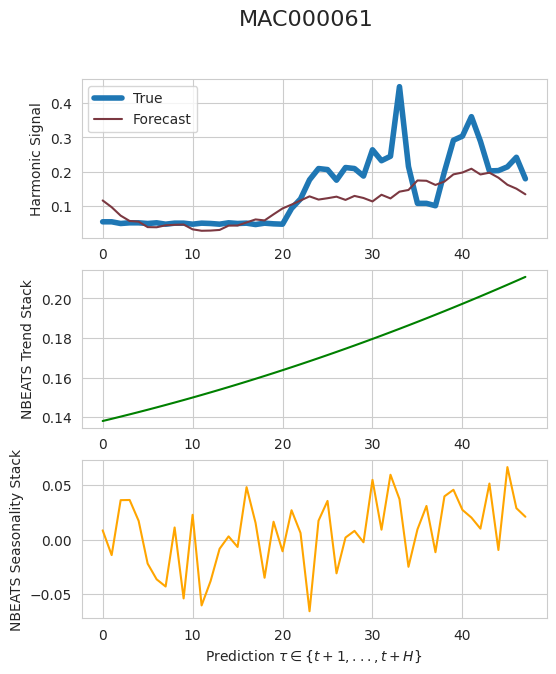

In [61]:
fig, ax = plt.subplots(3, 1, figsize=(6, 7))

fig.suptitle(training_df.LCLid[0], fontsize=16)
ax[0].plot(validation_df[validation_df.LCLid == training_df.LCLid[0]]['energy_consumption'].values, label='True', linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend()
ax[0].set_ylabel('Harmonic Signal')

ax[1].plot(y_hat[0,2]+y_hat[0,0], label='stack1', color="green")
ax[1].set_ylabel('NBEATS Trend Stack')

ax[2].plot(y_hat[0,1], label='stack2', color="orange")
ax[2].set_ylabel('NBEATS Seasonality Stack')
ax[2].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')

plt.show()
fig.savefig('imgs/chapter_16/nbeats_interp.png')

## TEST SET Predictions

In [34]:
h_test = len(test_df.timestamp.unique()) # horizon of the test set

if RETUNE == True:
    config = nbeats_best_config
else:
    config = loaded_config

models_test = [AutoNBEATS(h=h_test, 
                    config = config,
                    search_alg = None,
                    backend = 'ray')]

models_test = NeuralForecast(models=models_test, freq='30min')
models_test.fit(train_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption')

(_train_tune pid=131772) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=131772) Seed set to 1
(_train_tune pid=131772) GPU available: False, used: False
(_train_tune pid=131772) TPU available: False, using: 0 TPU cores
(_train_tune pid=131772) IPU available: False, using: 0 IPUs
(_train_tune pid=131772) HPU available: False, using: 0 HPUs
(_train_tune pid=131772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-49-00/_train_tune_a0d50_00000_0_2024-08-12_13-49-00/lightning_logs
(_train_tune pid=131772) 
(_train_tune pid=131772)   | Name         | Type          | Params
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 0 | loss         | MAE           | 0     
(_train_tune pid=13177

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.440]


(_train_tune pid=131772) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=131772) Seed set to 1


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


(_train_tune pid=131772) GPU available: False, used: False
(_train_tune pid=131772) TPU available: False, using: 0 TPU cores
(_train_tune pid=131772) IPU available: False, using: 0 IPUs
(_train_tune pid=131772) HPU available: False, using: 0 HPUs
(_train_tune pid=131772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-49-00/_train_tune_a0d50_00001_1_2024-08-12_13-49-00/lightning_logs
(_train_tune pid=131772) 
(_train_tune pid=131772)   | Name         | Type          | Params
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 0 | loss         | MAE           | 0     
(_train_tune pid=131772) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=131772) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=131772) 3 | blocks       | ModuleList    | 10.9 M
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 6.3 M     Trainable params
(_train_tune pid=131772) 

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.440]


(_train_tune pid=131772) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=131772) Seed set to 1
(_train_tune pid=131772) GPU available: False, used: False
(_train_tune pid=131772) TPU available: False, using: 0 TPU cores
(_train_tune pid=131772) IPU available: False, using: 0 IPUs
(_train_tune pid=131772) HPU available: False, using: 0 HPUs
(_train_tune pid=131772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-49-00/_train_tune_a0d50_00002_2_2024-08-12_13-49-00/lightning_logs
(_train_tune pid=131772) 
(_train_tune pid=131772)   | Name         | Type          | Params
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 0 | loss         | MAE           | 0     
(_train_tune pid=131772) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=131772) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=131772) 3 | blocks       | ModuleList    | 10.9 M
(_train_tune pid=131772) -------------

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=131772) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=131772) Seed set to 1


(_train_tune pid=131772) GPU available: False, used: False
(_train_tune pid=131772) TPU available: False, using: 0 TPU cores
(_train_tune pid=131772) IPU available: False, using: 0 IPUs
(_train_tune pid=131772) HPU available: False, using: 0 HPUs
(_train_tune pid=131772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-49-00/_train_tune_a0d50_00003_3_2024-08-12_13-49-00/lightning_logs
(_train_tune pid=131772) 
(_train_tune pid=131772)   | Name         | Type          | Params
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 0 | loss         | MAE           | 0     
(_train_tune pid=131772) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=131772) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=131772) 3 | blocks       | ModuleList    | 10.9 M
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 6.3 M     Trainable params
(_train_tune pid=131772) 

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.440]


(_train_tune pid=131772) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=131772) Seed set to 1


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


(_train_tune pid=131772) GPU available: False, used: False
(_train_tune pid=131772) TPU available: False, using: 0 TPU cores
(_train_tune pid=131772) IPU available: False, using: 0 IPUs
(_train_tune pid=131772) HPU available: False, using: 0 HPUs
(_train_tune pid=131772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-49-00/_train_tune_a0d50_00004_4_2024-08-12_13-49-00/lightning_logs
(_train_tune pid=131772) 
(_train_tune pid=131772)   | Name         | Type          | Params
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 0 | loss         | MAE           | 0     
(_train_tune pid=131772) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=131772) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=131772) 3 | blocks       | ModuleList    | 10.9 M
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 6.3 M     Trainable params
(_train_tune pid=131772) 

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.440]


(_train_tune pid=131772) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=131772) Seed set to 1
(_train_tune pid=131772) GPU available: False, used: False
(_train_tune pid=131772) TPU available: False, using: 0 TPU cores
(_train_tune pid=131772) IPU available: False, using: 0 IPUs
(_train_tune pid=131772) HPU available: False, using: 0 HPUs
(_train_tune pid=131772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-49-00/_train_tune_a0d50_00005_5_2024-08-12_13-49-00/lightning_logs
(_train_tune pid=131772) 
(_train_tune pid=131772)   | Name         | Type          | Params
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 0 | loss         | MAE           | 0     
(_train_tune pid=131772) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=131772) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=131772) 3 | blocks       | ModuleList    | 10.9 M
(_train_tune pid=131772) -------------

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.440]


(_train_tune pid=131772) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=131772) Seed set to 1
(_train_tune pid=131772) GPU available: False, used: False
(_train_tune pid=131772) TPU available: False, using: 0 TPU cores
(_train_tune pid=131772) IPU available: False, using: 0 IPUs
(_train_tune pid=131772) HPU available: False, using: 0 HPUs
(_train_tune pid=131772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-49-00/_train_tune_a0d50_00006_6_2024-08-12_13-49-00/lightning_logs
(_train_tune pid=131772) 
(_train_tune pid=131772)   | Name         | Type          | Params
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 0 | loss         | MAE           | 0     
(_train_tune pid=131772) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=131772) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=131772) 3 | blocks       | ModuleList    | 10.9 M
(_train_tune pid=131772) -------------

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=131772) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=131772) Seed set to 1


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


(_train_tune pid=131772) GPU available: False, used: False
(_train_tune pid=131772) TPU available: False, using: 0 TPU cores
(_train_tune pid=131772) IPU available: False, using: 0 IPUs
(_train_tune pid=131772) HPU available: False, using: 0 HPUs
(_train_tune pid=131772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-49-00/_train_tune_a0d50_00007_7_2024-08-12_13-49-00/lightning_logs
(_train_tune pid=131772) 
(_train_tune pid=131772)   | Name         | Type          | Params
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 0 | loss         | MAE           | 0     
(_train_tune pid=131772) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=131772) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=131772) 3 | blocks       | ModuleList    | 10.9 M
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 6.3 M     Trainable params
(_train_tune pid=131772) 

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.440]


(_train_tune pid=131772) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=131772) Seed set to 1


Sanity Checking DataLoader 0:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 1/2 [00:00<00:00, 102.62it/s]


(_train_tune pid=131772) GPU available: False, used: False
(_train_tune pid=131772) TPU available: False, using: 0 TPU cores
(_train_tune pid=131772) IPU available: False, using: 0 IPUs
(_train_tune pid=131772) HPU available: False, using: 0 HPUs
(_train_tune pid=131772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-49-00/_train_tune_a0d50_00008_8_2024-08-12_13-49-00/lightning_logs
(_train_tune pid=131772) 
(_train_tune pid=131772)   | Name         | Type          | Params
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 0 | loss         | MAE           | 0     
(_train_tune pid=131772) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=131772) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=131772) 3 | blocks       | ModuleList    | 10.9 M
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 6.3 M     Trainable params
(_train_tune pid=131772) 

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.440]


(_train_tune pid=131772) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=131772) Seed set to 1


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


(_train_tune pid=131772) GPU available: False, used: False
(_train_tune pid=131772) TPU available: False, using: 0 TPU cores
(_train_tune pid=131772) IPU available: False, using: 0 IPUs
(_train_tune pid=131772) HPU available: False, using: 0 HPUs
(_train_tune pid=131772) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-12_13-49-00/_train_tune_a0d50_00009_9_2024-08-12_13-49-00/lightning_logs
(_train_tune pid=131772) 
(_train_tune pid=131772)   | Name         | Type          | Params
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 0 | loss         | MAE           | 0     
(_train_tune pid=131772) 1 | padder_train | ConstantPad1d | 0     
(_train_tune pid=131772) 2 | scaler       | TemporalNorm  | 0     
(_train_tune pid=131772) 3 | blocks       | ModuleList    | 10.9 M
(_train_tune pid=131772) -----------------------------------------------
(_train_tune pid=131772) 6.3 M     Trainable params
(_train_tune pid=131772) 

Epoch 19:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 4/5 [00:03<00:00,  1.29it/s, v_num=0, train_loss_step=1.460, train_loss_epoch=1.440]


Seed set to 1


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.440]


(_train_tune pid=131772) `Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 10.9 M
-----------------------------------------------
6.3 M     Trainable params
4.6 M     Non-trainable params
10.9 M    Total params
43.417    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.


In [36]:
pred_df_test =  models_test.predict(futr_df=test_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df_test = pred_df_test.merge(test_df[['LCLid','timestamp','energy_consumption']], on=['LCLid','timestamp'], how='left')
pred_df_test.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LCLid           timestamp  AutoNBEATS  energy_consumption
0  MAC000061 2014-01-01 00:00:00    0.189905               0.165
1  MAC000061 2014-01-01 00:30:00    0.146666               0.167
2  MAC000061 2014-01-01 01:00:00    0.168894               0.150
3  MAC000061 2014-01-01 01:30:00    0.175748               0.091
4  MAC000061 2014-01-01 02:00:00    0.127384               0.047

In [37]:
fcst_mase = partial(mase, seasonality=48)

# Get metrics for individual LCLid's
nbeats_metrics_test = evaluate(pred_df_test, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

# Get aggregated metrics for across all LCLid's by model
nbeats_metrics_agg_test = evaluate(pred_df_test, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [38]:
nbeats_metrics_agg_test

metric  AutoNBEATS
0   rmse    0.267236
1    mae    0.185894
2    mse    0.142403
3   mase    1.602875

In [63]:
nbeats_metrics_test.head()

LCLid metric  AutoNBEATS
0  MAC000061   rmse    0.094887
1  MAC000062   rmse    0.296364
2  MAC000066   rmse    0.132564
3  MAC000086   rmse    0.187779
4  MAC000126   rmse    0.170569

In [ ]:
nbeats_metrics_test

In [65]:
nbeats_metrics_agg_test.to_pickle(output/'nbeats_metrics_agg_test.pkl')
nbeats_metrics_test.to_pickle(output/'nbeats_metrics_test.pkl')